# 📊 Chronic Kidney Disease Classification and Explainability using Neuro-Symbolic AI

In this notebook, we build and evaluate a deep learning model for classifying **Chronic Kidney Disease (CKD)** using clinical data, with a strong focus on **model interpretability**. CKD is a critical health condition that requires early and accurate diagnosis — making explainable AI especially important in this context.

We follow a two-stage approach:

1. **Deep Learning for Prediction**:
   - We preprocess the CKD dataset (handling missing values, encoding categorical features, normalization).
   - A neural network is trained to classify patients as having CKD or not, based on clinical features.

2. **Neuro-Symbolic AI for Explanation**:
   - Beyond prediction accuracy, we apply symbolic reasoning techniques (e.g., rule extraction) to understand *why* the model makes certain decisions.
   - This hybrid method aims to bridge the gap between black-box neural networks and interpretable, logic-based explanations — critical for medical applications.

Throughout the notebook, we explore:
- How network architecture affects both performance and interpretability.
- How symbolic rules can be derived from the model’s internal behavior.
- Trade-offs between accuracy and transparency in medical AI systems.

---
This work contributes to the broader effort of making AI in healthcare **trustworthy, interpretable, and clinically useful**.


In [1]:
# 📦 Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🧪 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# 🔥 Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 🧠 Explainability Tools
import shap  # For SHAP value explanations
import lime
import lime.lime_tabular

# ⚖️ Symbolic Rule Extraction (Optional — can be used for logic extraction later)
# Install pysr if not already available: pip install pysr
try:
    from pysr import PySRRegressor
except ImportError:
    print("PySR not installed. Install it via: pip install pysr")

# 📊 Plotting Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# ⚙️ Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

c:\Users\priya\anaconda3\Lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: c:\users\priya\anaconda3\lib\site-packages\juliapkg\juliapkg.json
[juliapkg] Found dependencies: c:\users\priya\anaconda3\lib\site-packages\pysr\juliapkg.json
[juliapkg] Found dependencies: c:\users\priya\anaconda3\lib\site-packages\juliacall\juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.5 to C:\Users\priya\anaconda3\julia_env\pyjuliapkg\install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/winnt/x64/1.11/julia-1.11.5-win64.zip
             downloaded 15.9 MB of 261.5 MB
             downloa

## 📄 Dataset Overview: Chronic Kidney Disease (CKD) Dataset

This project uses the **Chronic Kidney Disease (CKD)** dataset sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease). The dataset is specifically curated to support early-stage CKD detection using routine clinical and physiological indicators.

### 🏥 Dataset Origin
- **Medical Expert**: Dr. P. Soundarapandian, M.D., D.M (Senior Consultant Nephrologist), Apollo Hospitals, Tamil Nadu, India.
- **Data Creator**: L. Jerlin Rubini (Research Scholar, Alagappa University)
- **Supervisor**: Dr. P. Eswaran (Assistant Professor, Dept. of CSE, Alagappa University)
- **Release Date**: July 2015

---

### 📊 Key Dataset Characteristics
- **Instances**: 400 total samples
  - 250 labeled as **CKD**
  - 150 labeled as **not CKD**
- **Attributes**: 24 features + 1 class label (Total: 25)
  - 11 **numerical** attributes
  - 14 **categorical** (nominal) attributes
- **Missing Values**: Yes — represented by `"?"`
- **Target Variable**: `class` — with values: `ckd` and `notckd`

---

### 🔍 Attribute Description (Selected)
| Feature | Type | Description |
|--------|------|-------------|
| `age` | Numerical | Age in years |
| `bp` | Numerical | Blood pressure (mm/Hg) |
| `sg` | Categorical | Specific gravity (e.g. 1.010, 1.015, etc.) |
| `al` | Categorical | Albumin levels (0–5) |
| `su` | Categorical | Sugar levels (0–5) |
| `rbc` | Categorical | Red blood cells (normal/abnormal) |
| `pc` | Categorical | Pus cell (normal/abnormal) |
| `bgr`, `bu`, `sc` | Numerical | Blood glucose, urea, and serum creatinine |
| `hemo` | Numerical | Hemoglobin (gms) |
| `htn`, `dm`, `cad`, `ane` | Categorical | Medical history (yes/no) |
| `appet` | Categorical | Appetite (good/poor) |
| `class` | Target | `ckd` or `notckd` |

---

### 🧠 Why This Dataset?
CKD is a progressive condition, and early detection is vital. This dataset provides a compact yet informative set of features, making it suitable for training deep learning models while enabling symbolic reasoning for explainability.

In the next steps, we will clean and preprocess this data to prepare it for modeling.


In [16]:
# 📥 Install and Import Required Package
# Make sure ucimlrepo is installed
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset by ID
chronic_kidney_disease = fetch_ucirepo(id=336)

# Extract features and labels
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)

# Strip whitespace from all object columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


# Save to CSV
csv_path = "chronic_kidney_disease.csv"
df.to_csv(csv_path, index=False)

print(f"Dataset saved to {csv_path}")

Dataset saved to chronic_kidney_disease.csv


In [17]:
import pandas as pd

# Load dataset
df = pd.read_csv("chronic_kidney_disease.csv")

# Prepare summary data
summary = []

for col in df.columns:
    col_data = df[col]
    summary.append({
        "Variable": col,
        "Data Type": col_data.dtype,
        "Missing (NaN)": col_data.isna().sum(),
        "Unique Values": col_data.nunique(),
        "Mean": col_data.mean() if pd.api.types.is_numeric_dtype(col_data) else None,
        "Std Dev": col_data.std() if pd.api.types.is_numeric_dtype(col_data) else None,
        "Min": col_data.min() if pd.api.types.is_numeric_dtype(col_data) else None,
        "Max": col_data.max() if pd.api.types.is_numeric_dtype(col_data) else None
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Display as table
from IPython.display import display
display(summary_df)

Variable Data Type  Missing (NaN)  Unique Values         Mean      Std Dev  \
0       age   float64              9             76    51.483376    17.169714   
1        bp   float64             12             10    76.469072    13.683637   
2        sg   float64             47              5     1.017408     0.005717   
3        al   float64             46              6     1.016949     1.352679   
4        su   float64             49              6     0.450142     1.099191   
5       rbc    object            152              2          NaN          NaN   
6        pc    object             65              2          NaN          NaN   
7       pcc    object              4              2          NaN          NaN   
8        ba    object              4              2          NaN          NaN   
9       bgr   float64             44            146   148.036517    79.281714   
10       bu   float64             19            118    57.425722    50.503006   
11       sc   float64             17             84     3.072454     5.741126   
12      sod   float64             87             34   137.528754    10.408752   
13      pot   float64             88             40     4.627244     3.193904   
14     hemo   float64             52            115    12.526437     2.912587   
15      pcv   float64             71             42    38.884498     8.990105   
16     wbcc   float64            106             89  8406.122449  2944.474190   
17     rbcc   float64            131             45     4.707435     1.025323   
18      htn    object              2              2          NaN          NaN   
19       dm    object              2              2          NaN          NaN   
20      cad    object              2              2          NaN          NaN   
21    appet    object              1              2          NaN          NaN   
22       pe    object              1              2          NaN          NaN   
23      ane    object              1              2          NaN          NaN   
24    class    object              0              2          NaN          NaN   

         Min        Max  
0      2.000     90.000  
1     50.000    180.000  
2      1.005      1.025  
3      0.000      5.000  
4      0.000      5.000  
5        NaN        NaN  
6        NaN        NaN  
7        NaN        NaN  
8        NaN        NaN  
9     22.000    490.000  
10     1.500    391.000  
11     0.400     76.000  
12     4.500    163.000  
13     2.500     47.000  
14     3.100     17.800  
15     9.000     54.000  
16  2200.000  26400.000  
17     2.100      8.000  
18       NaN        NaN  
19       NaN        NaN  
20       NaN        NaN  
21       NaN        NaN  
22       NaN        NaN  
23       NaN        NaN  
24       NaN        NaN

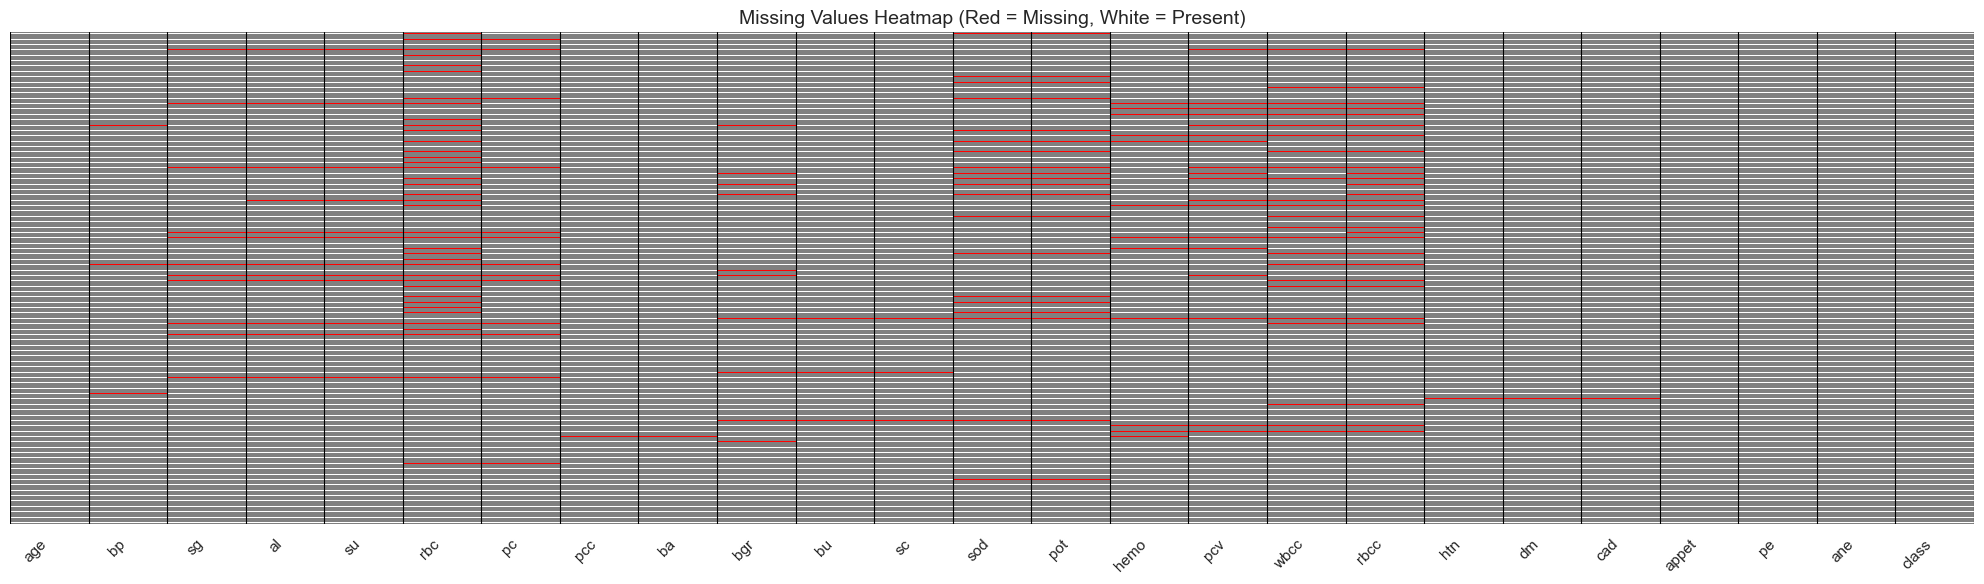

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create binary matrix: 1 = NaN (missing), 0 = present
nan_binary = df.isnull().astype(int)

# Plot
plt.figure(figsize=(20, 6))
sns.heatmap(
    nan_binary,
    cmap=['white', 'red'],  # 0: white, 1: red
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

# Add vertical lines between variables
for i in range(len(df.columns) + 1):
    plt.axvline(i, color='black', linewidth=0.8)

# Formatting
plt.title("Missing Values Heatmap (Red = Missing, White = Present)", fontsize=14)
plt.xticks(ticks=np.arange(0.5, len(df.columns), 1), labels=df.columns, rotation=45, ha='right')
plt.yticks([])  # Hide row labels
plt.tight_layout()
plt.show()

## 🤖 Missing Value Imputation using KNN Imputer

In this section, we address missing values in our dataset using a **K-Nearest Neighbors (KNN) Imputer**, a more advanced and context-aware method compared to mean or mode imputation.

---

### 🧠 What is KNN Imputation?

The **KNN Imputer** fills in missing values by finding the "nearest" examples (rows) in the dataset that are most similar (based on feature similarity), and using their known values to estimate the missing one.

Instead of filling in missing values with global statistics like the mean or mode, KNN looks **locally** — for each row with a missing value, it finds the **K most similar rows** that *have* that value, and averages their values (for numerical features) or uses a majority vote (for categorical features).

---

### ⚙️ How It Works (Step-by-Step)

1. **Distance Calculation**: For a row with a missing value, compute the distance (typically **Euclidean distance**) to every other row in the dataset — ignoring the columns that are missing in either row.
   
2. **Find Neighbors**: Identify the **K rows** (examples) that are closest in terms of feature similarity.

3. **Aggregate**:
   - For **numerical features**, impute using the **mean** of the K neighbors.
   - For **categorical features**, use the **most frequent category** among the K neighbors.

---

### 📐 Mathematical Intuition

Let:

- $x_i \in \mathbb{R}^d$ be a sample with missing values.
- $\mathcal{N}_K(x_i)$ be the set of its **K nearest neighbors**.
- $x_j \in \mathcal{N}_K(x_i)$ be a neighbor that has the missing value filled.


Then, for a missing feature \( f \), the imputed value is:

**For numeric features:**

$$
\hat{x}_{i,f} = \frac{1}{K} \sum_{x_j \in \mathcal{N}_K(x_i)} x_{j,f}
$$

**For categorical features:**

$$
\hat{x}_{i,f} = \text{mode}\left(\{x_{j,f} \;|\; x_j \in \mathcal{N}_K(x_i)\}\right)
$$

---

### 📌 Benefits of KNN Imputation
- Takes **correlation between features** into account.
- Can preserve complex **data structure** better than global imputation.
- Adaptive to **local distributions**.

### ⚠️ Limitations
- **Computationally expensive** for large datasets.
- Sensitive to the **choice of K** and **distance metric**.
- Doesn't work well if too many features are missing per row.

---

In the next cell, we will use `sklearn.impute.KNNImputer` to fill in missing values across both numerical and categorical features (after label encoding).


C:\Users\priya\AppData\Local\Temp\ipykernel_18552\3219352953.py:13: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


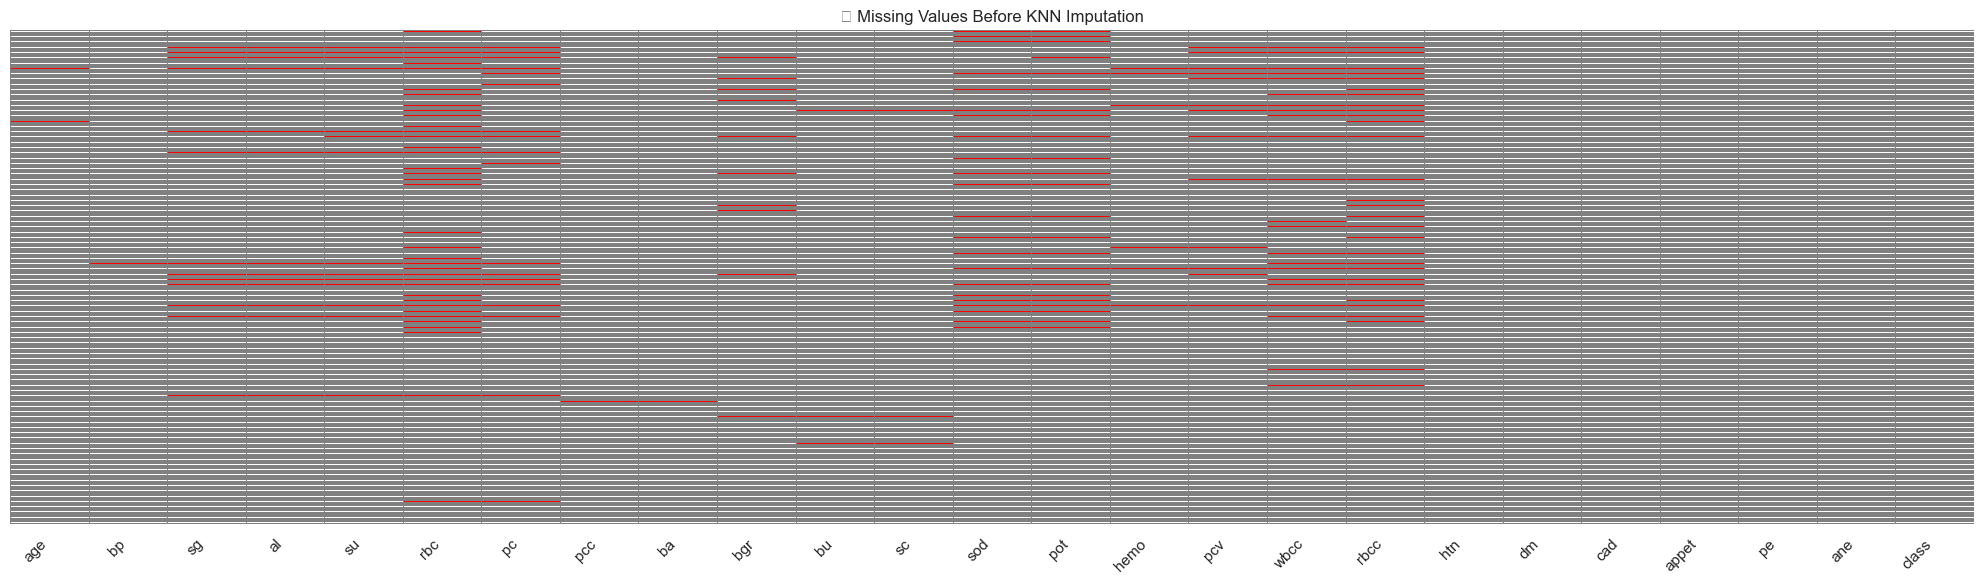

C:\Users\priya\AppData\Local\Temp\ipykernel_18552\3219352953.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df.groupby("class").apply(lambda group: group.isnull().sum().sum()))


Missing values per class label before imputation:
class
ckd       908
notckd    104
dtype: int64


C:\Users\priya\AppData\Local\Temp\ipykernel_18552\3219352953.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


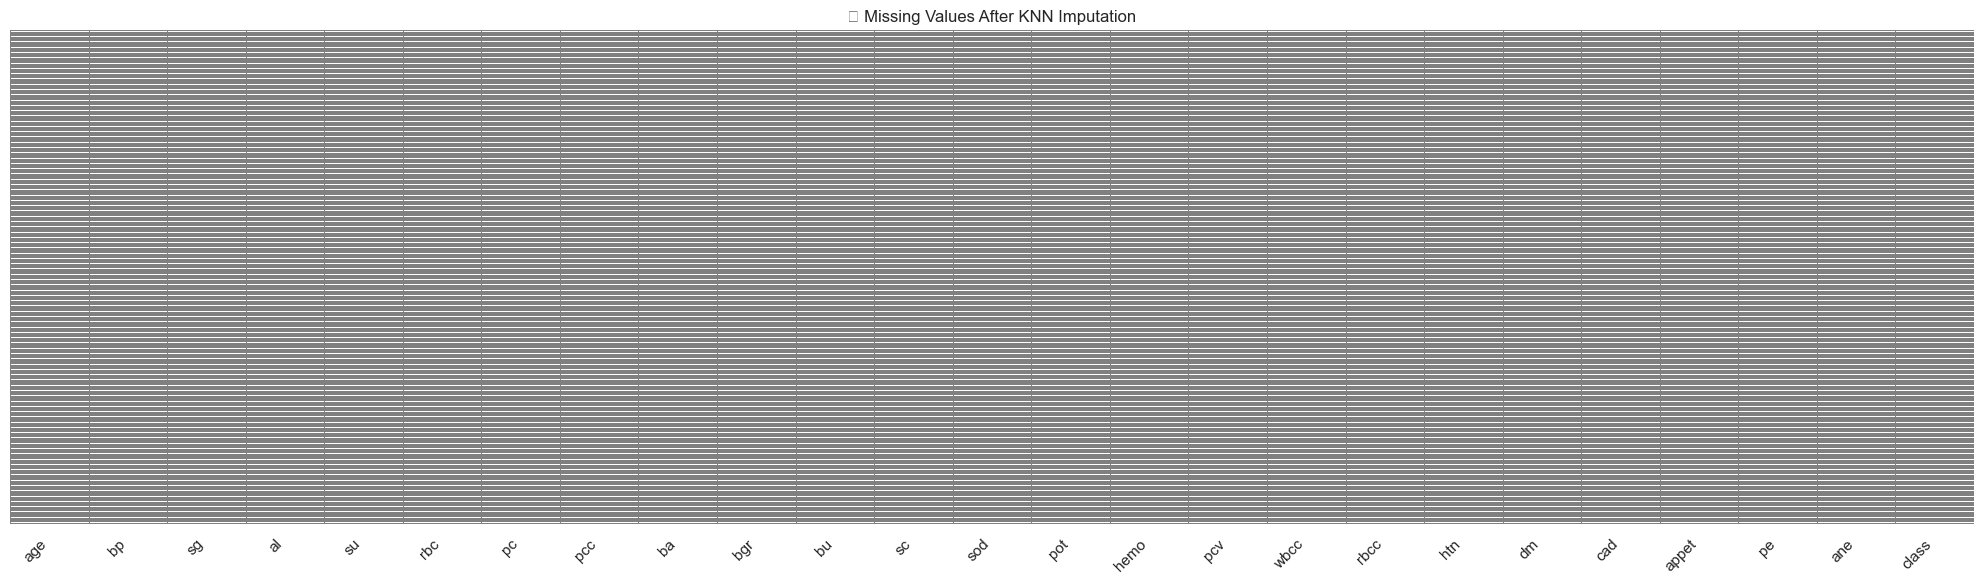


Target class distribution before imputation:
class
ckd       250
notckd    150
Name: count, dtype: int64

Target class distribution after KNN imputation:
class
0    250
1    150
Name: count, dtype: int64


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Visualize missing values BEFORE imputation
plt.figure(figsize=(20, 6))
sns.heatmap(df.isnull(), cbar=False, cmap=['white', 'red'], linewidths=0.5, linecolor='gray')
plt.title("🔴 Missing Values Before KNN Imputation")
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.show()

# Show missing target class rows
print("Missing values per class label before imputation:")
print(df.groupby("class").apply(lambda group: group.isnull().sum().sum()))

# Encode all categorical columns (including target)
df_encoded = df.copy()
encoders = {}
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        encoders[col] = le  # Store for possible decoding later

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_encoded)
df_imputed = pd.DataFrame(df_imputed_array, columns=df.columns)

# Round class back to 0 or 1
df_imputed['class'] = df_imputed['class'].round().astype(int)

# Visualize missing values AFTER imputation
plt.figure(figsize=(20, 6))
sns.heatmap(df_imputed.isnull(), cbar=False, cmap=['white', 'red'], linewidths=0.5, linecolor='gray')
plt.title("✅ Missing Values After KNN Imputation")
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.show()

# Compare class distribution
print("\nTarget class distribution before imputation:")
print(df['class'].value_counts(dropna=False))

print("\nTarget class distribution after KNN imputation:")
print(df_imputed['class'].value_counts())


## 🧭 Dimensionality Reduction and Visualization using PCA

In real-world datasets like ours (Chronic Kidney Disease), we often deal with **many features** — some of which may be redundant, correlated, or noisy. Visualizing such high-dimensional data directly is impossible, but **dimensionality reduction** techniques like **PCA** allow us to uncover meaningful patterns in a simplified form.

---

### ❓ Why Dimensionality Reduction?

- 🔍 **Visualization**: Humans can't directly visualize more than 3 dimensions. PCA lets us reduce the feature space to 2D or 3D for intuitive plotting.
- 🧹 **Noise Reduction**: By projecting data into directions of maximum variance, PCA naturally filters out low-variance noise.
- ⚡ **Efficiency**: Reduced dimensions can speed up downstream algorithms like clustering or classification.
- 🔄 **Correlation Elimination**: PCA transforms correlated features into **uncorrelated** (orthogonal) components.

---

### 🧠 What is PCA?

**Principal Component Analysis (PCA)** is a linear transformation technique that projects data into a new coordinate system such that:

- **PC1 (Principal Component 1)**: Captures the **maximum variance** in the data.
- **PC2**: Captures the next highest variance, orthogonal to PC1.
- And so on...

Each **principal component** is a **linear combination** of the original features.

---

### 📐 Mathematical Formulation

Given:
- A dataset $X \in \mathbb{R}^{n \times d}$ with $n$ samples and $d$ features.

#### Step 1: Center the Data

$$
X_{\text{centered}} = X - \mu
$$

Where $\mu$ is the mean of each feature.

#### Step 2: Compute the Covariance Matrix

$$
\Sigma = \frac{1}{n - 1} X_{\text{centered}}^T X_{\text{centered}}
$$

#### Step 3: Eigen Decomposition

Find **eigenvectors** and **eigenvalues** of $\Sigma$:

- **Eigenvectors** $\rightarrow$ Directions of the new axes (principal components)  
- **Eigenvalues** $\rightarrow$ Variance captured by each component

#### Step 4: Project Data

Choose the top $k$ eigenvectors and project the data:

$$
Z = X_{\text{centered}} \cdot W_k
$$

Where $W_k \in \mathbb{R}^{d \times k}$ contains the top $k$ eigenvectors.

---

### 📊 Why PCA is Useful Here

- Helps us **visualize the CKD dataset** in 2D or 3D while preserving as much variance as possible.
- Helps explore **class separability** between `ckd` and `notckd`.
- Reduces noise and redundancy by collapsing correlated medical features (e.g., hemoglobin & red cell count) into simpler axes.
- Aids interpretation: top contributing features to each principal component can reveal **latent clinical trends**.

In the next cell, we’ll apply PCA to reduce our CKD dataset to **3 components** and visualize the samples in 3D, colored by class.


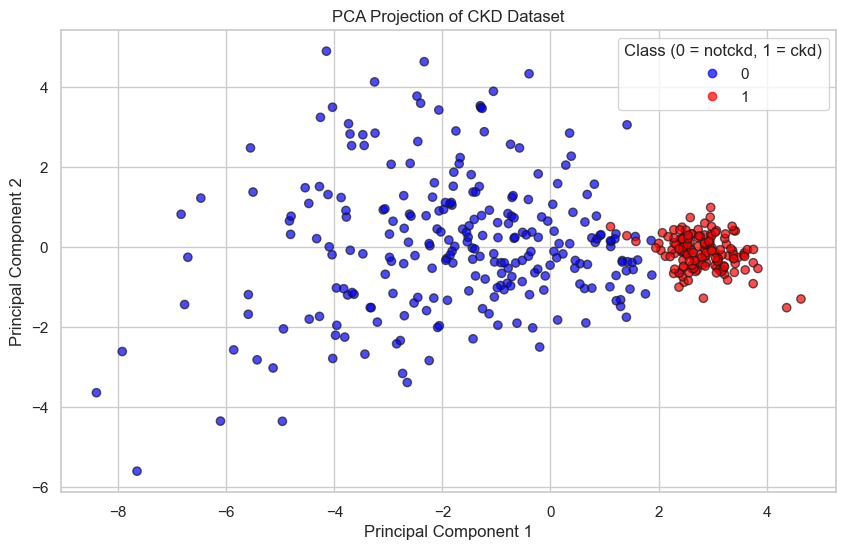

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Drop target temporarily
features = df_imputed.drop("class", axis=1)
labels = df_imputed["class"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='bwr', alpha=0.7, edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of CKD Dataset")
plt.legend(*scatter.legend_elements(), title="Class (0 = notckd, 1 = ckd)")
plt.grid(True)
plt.show()


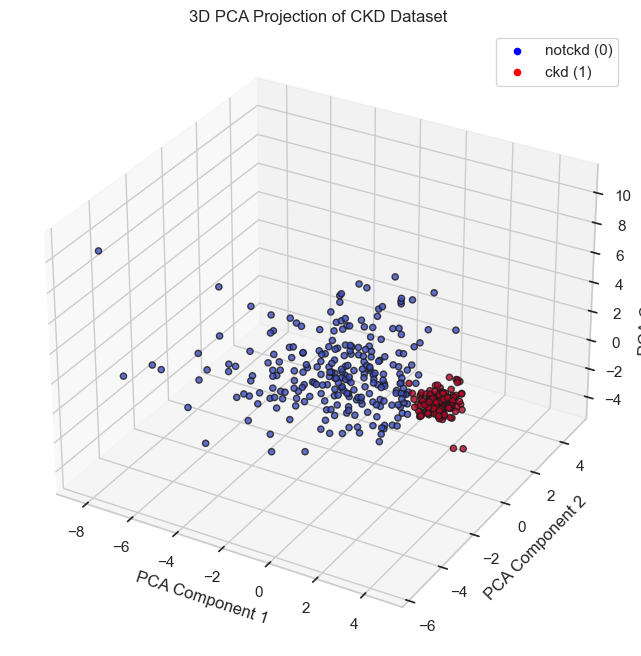

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

# Separate features and labels
features = df_imputed.drop("class", axis=1)
labels = df_imputed["class"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA for 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Plot in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels, cmap='coolwarm', edgecolor='k', alpha=0.8
)

# Axis labels and title
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA Projection of CKD Dataset")

# Legend
legend_labels = ['notckd (0)', 'ckd (1)']
for i in [0, 1]:
    ax.scatter([], [], [], c='blue' if i == 0 else 'red', label=legend_labels[i])
ax.legend()

plt.show()


Using device: cuda
Epoch 1/50 | Train Loss: 21.8749, Train Acc: 0.5625 | Val Loss: 1.2269, Val Acc: 0.4125
✅ Model saved to 'ckd_model.pt' at epoch=0
Epoch 2/50 | Train Loss: 4.6897, Train Acc: 0.4938 | Val Loss: 0.6613, Val Acc: 0.6000
✅ Model saved to 'ckd_model.pt' at epoch=1
Epoch 3/50 | Train Loss: 2.6702, Train Acc: 0.5437 | Val Loss: 1.8384, Val Acc: 0.6250
✅ Model saved to 'ckd_model.pt' at epoch=2
Epoch 4/50 | Train Loss: 1.1833, Train Acc: 0.6250 | Val Loss: 0.6956, Val Acc: 0.6250
Epoch 5/50 | Train Loss: 0.8002, Train Acc: 0.6000 | Val Loss: 0.5508, Val Acc: 0.7250
✅ Model saved to 'ckd_model.pt' at epoch=4
Epoch 6/50 | Train Loss: 0.5363, Train Acc: 0.7094 | Val Loss: 0.5410, Val Acc: 0.6500
Epoch 7/50 | Train Loss: 0.5153, Train Acc: 0.7375 | Val Loss: 0.8191, Val Acc: 0.5500
Epoch 8/50 | Train Loss: 0.5397, Train Acc: 0.6937 | Val Loss: 0.4797, Val Acc: 0.7500
✅ Model saved to 'ckd_model.pt' at epoch=7
Epoch 9/50 | Train Loss: 0.5119, Train Acc: 0.7312 | Val Loss: 0.3858

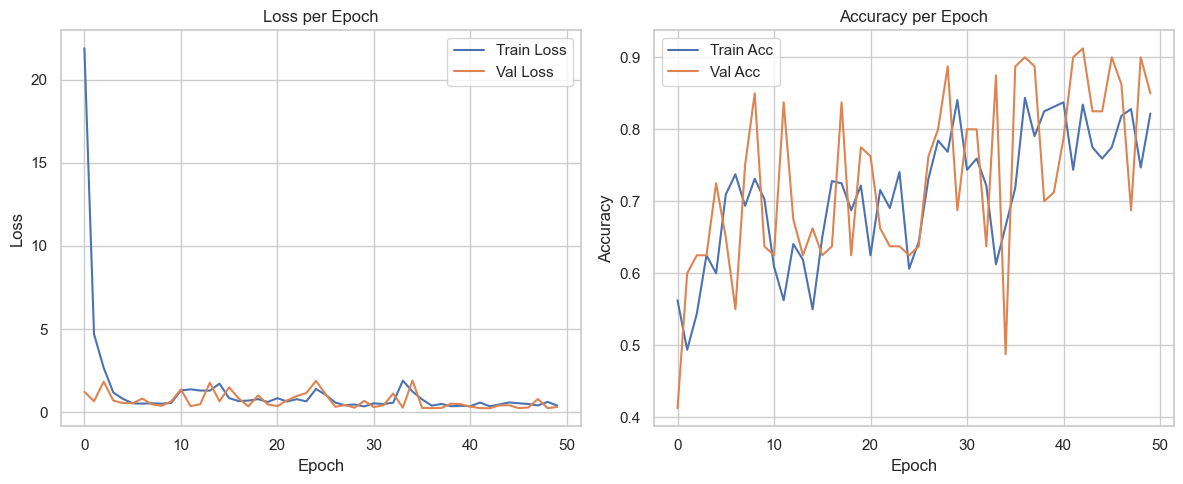

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare features and labels
X = df_imputed.drop("class", axis=1).values
y = df_imputed["class"].values

# Stratified split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define a simple neural net
class CKDClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
model = CKDClassifier(X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses, val_losses, train_accs, val_accs = [], [], [], []

best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")
    if (correct/total) > best_val_acc:
        best_val_acc = (correct/total)
        torch.save(model.state_dict(), "ckd_model.pt")
        print(f"✅ Model saved to 'ckd_model.pt' at epoch={epoch}")

# Plot training history
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\priya\AppData\Local\Temp\ipykernel_18552\2914295645.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ckd_model.pt", map_lo

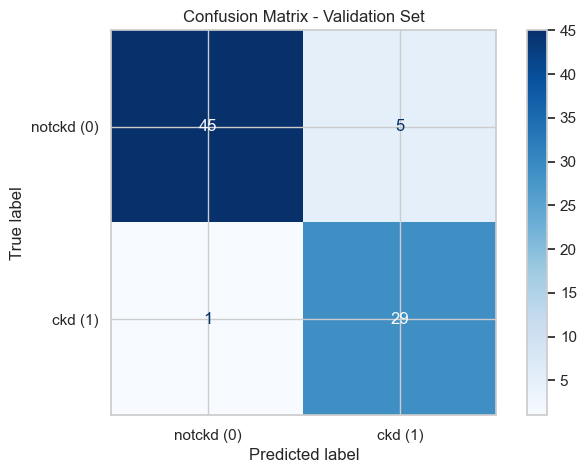

✅ Evaluation Metrics:
Accuracy : 0.9250
Precision: 0.8529
Recall   : 0.9667
F1-Score : 0.9062


In [37]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


model.load_state_dict(torch.load("best_ckd_model.pt", map_location=device))
model.eval()

# Inference
with torch.no_grad():
    outputs = model(X_val_tensor)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    ground_truth = y_val_tensor.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(ground_truth, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["notckd (0)", "ckd (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Classification Metrics
acc = accuracy_score(ground_truth, predictions)
prec = precision_score(ground_truth, predictions)
rec = recall_score(ground_truth, predictions)
f1 = f1_score(ground_truth, predictions)

print(f"✅ Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")


## 🌳 Decision Trees and Their Visualization

### 🧠 What is a Decision Tree?

A **Decision Tree** is a supervised machine learning algorithm used for **classification** and **regression** tasks. It works by learning simple decision rules from data features to predict the target label.

Each **internal node** represents a decision based on a feature, each **branch** represents the outcome of that decision, and each **leaf node** represents a class label or prediction.

In the case of binary classification (like `ckd` vs `notckd`), the tree keeps splitting the dataset based on feature thresholds that reduce uncertainty (measured by **Gini impurity** or **entropy**).

---

### ⚙️ How Does It Work?

At each node, the algorithm chooses the feature and split point that produces the best separation between classes. For example:

> "If `serum creatinine ≤ 1.5`, go left; else, go right."

This splitting continues recursively until:
- Maximum depth is reached,
- Minimum samples per leaf are met, or
- Pure leaf nodes (all one class) are formed.

---

### 📊 Why Plot a Decision Tree?

Visualizing the tree structure helps us:

- 🔍 **Understand the logic** the model uses to make decisions.
- 📎 **Identify important features** (used at top levels of the tree).
- 💡 **Interpret decision paths**, especially useful in medical applications.
- 🚨 **Spot overfitting**, by looking at tree depth or very small leaves.
- 📑 **Explainability**: great for reports and communicating model behavior to non-technical stakeholders.

---

### ✅ In This Notebook

We trained a decision tree classifier on the CKD dataset and plotted it. The visualization shows:
- How features like `sc` (serum creatinine) or `hemo` (hemoglobin) are used,
- Where the splits occur,
- The distribution of classes at each node.

This plot serves as a **transparent window into the model's reasoning**, making it a valuable tool in healthcare and other critical domains.


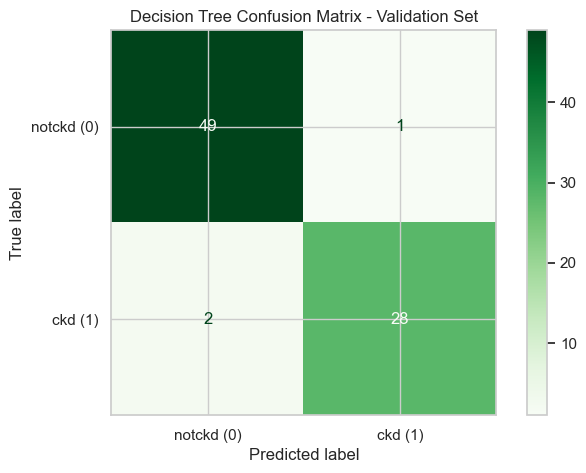

🌳 Decision Tree Evaluation Metrics:
Accuracy : 0.9625
Precision: 0.9655
Recall   : 0.9333
F1-Score : 0.9492


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt

# Train Decision Tree Classifier
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

# Predict
y_pred_tree = tree_model.predict(X_val)

# Confusion Matrix
cm_tree = confusion_matrix(y_val, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["notckd (0)", "ckd (1)"])
disp_tree.plot(cmap="Greens", values_format="d")
plt.title("Decision Tree Confusion Matrix - Validation Set")
plt.show()

# Metrics
acc = accuracy_score(y_val, y_pred_tree)
prec = precision_score(y_val, y_pred_tree)
rec = recall_score(y_val, y_pred_tree)
f1 = f1_score(y_val, y_pred_tree)

print(f"🌳 Decision Tree Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

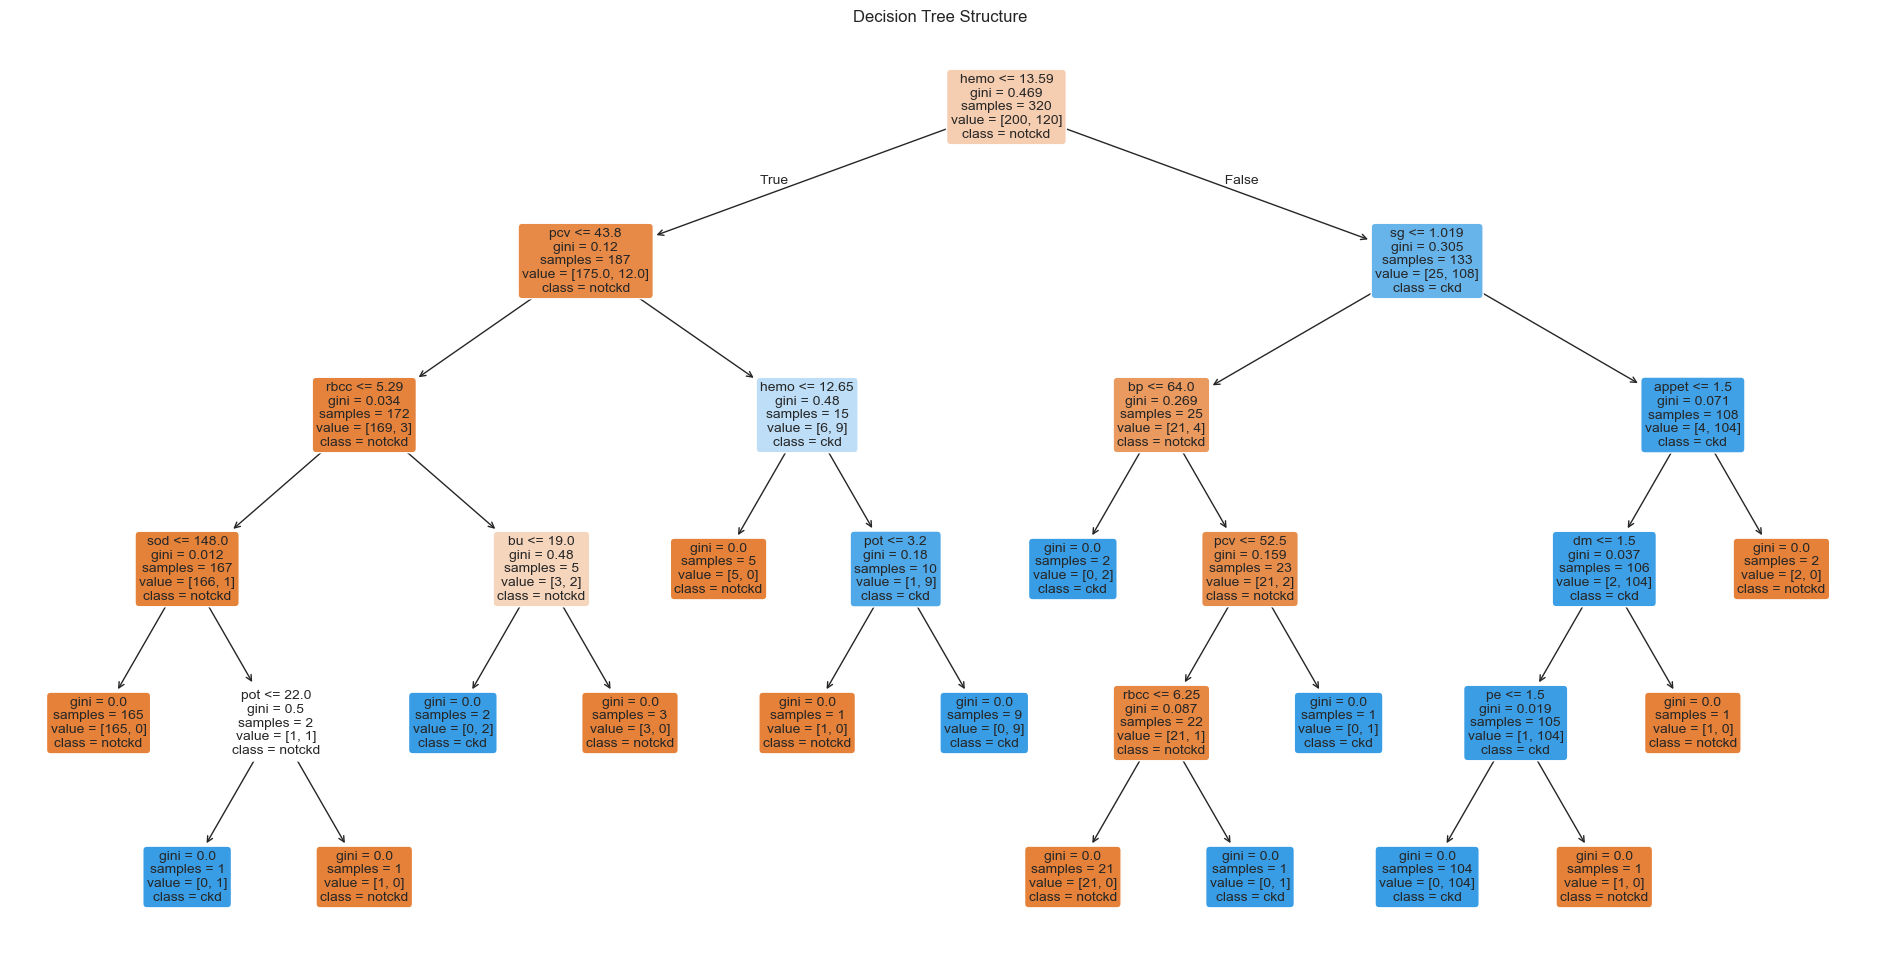

✅ Tree saved as decision_tree_ckd.png at 600 DPI


In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create figure
fig = plt.figure(figsize=(24, 12))
plot_tree(
    tree_model,
    feature_names=df_imputed.drop("class", axis=1).columns,
    class_names=["notckd", "ckd"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()

# Save as high-resolution PNG
fig.savefig("decision_tree_ckd.png", dpi=1200, bbox_inches="tight")
print("✅ Tree saved as decision_tree_ckd.png at 600 DPI")


## 🧠 What is Symbolic AI?

**Symbolic AI** is a branch of artificial intelligence that uses **explicit logic, rules, and symbolic reasoning** to make decisions. Unlike black-box models like neural networks, symbolic AI aims to produce **interpretable and human-understandable rules**.

In our case, we aim to:

> **Extract transparent, human-readable rules from the CKD dataset** that explain when a patient is likely to have Chronic Kidney Disease.

---

## ✅ Common Approaches to Symbolic AI on Tabular Data

| Approach                     | Description                                     | Tools                                         |
|-----------------------------|-------------------------------------------------|-----------------------------------------------|
| **Rule-Based Learners**     | Learn IF–THEN rules from data                  | `sklearn` + `skope-rules`, `imodels`, `PyCaret` |
| **Symbolic Regression**     | Learn mathematical expressions for prediction  | `PySR`, `gplearn`                             |
| **Decision Trees** (done)   | Logic trees that split data using thresholds   | `sklearn.tree`                                |
| **Neuro-Symbolic**          | Combine neural networks with logic rules       | `DeepRED`, `Logic Tensor Networks (LTNs)`     |

---

## 🔍 Why Symbolic AI for CKD?

- 📖 **Interpretability**: Medical practitioners can read and verify model behavior.
- 📊 **Auditability**: Rule-based models make it easy to trace how a decision was made.
- 🧬 **Insight Discovery**: Helps reveal clinically relevant thresholds (e.g., "if serum creatinine > 1.3").

In the next steps, we’ll use a symbolic regression tool like **PySR** to automatically derive compact, interpretable rules that predict CKD from clinical data.


## 🧠 Neuro-Symbolic AI for CKD Prediction

### 🔍 What is Neuro-Symbolic AI?

**Neuro-Symbolic AI** combines the power of **neural networks (deep learning)** with the **interpretability and structure** of **symbolic reasoning** (logic rules, constraints, knowledge graphs). The goal is to build models that are both:
- **Accurate** (like deep learning), and
- **Explainable** and **logically grounded** (like symbolic AI)

---

### 🧪 Why Use Neuro-Symbolic AI for CKD?

In medical domains like **chronic kidney disease prediction**, we face two major challenges:
1. **Prediction**: Accurately determine if a patient is at risk.
2. **Explanation**: Justify *why* that decision was made in a human-understandable way.

Neuro-symbolic methods aim to **preserve the predictive power** of deep models while **extracting symbolic rules** or incorporating **domain knowledge**, making them ideal for high-stakes fields like healthcare.

---

### 🧩 How Does It Work?

There are two typical flows:

#### 1. **NN → Logic** (Post-hoc Rule Extraction)
- Train a neural network (e.g., MLP classifier)
- Analyze neuron activations or decision boundaries
- Extract symbolic rules (IF–THEN) using tools like:
  - `DeepRED` (decomposes NNs into decision trees)
  - `Trepan` (mimics NN behavior with a decision tree)

#### 2. **Logic + NN → Joint Learning**
- Embed **logical constraints** into the NN loss function or architecture
- Learn models that follow known medical rules like:
  > "If serum creatinine > 1.5 and hemoglobin < 10, then CKD likely"

This is done using frameworks like:
- `Logic Tensor Networks (LTN)`
- `NeSy` (e.g., NeSy-SatNet, NeuroLog)

---

### 🎯 Benefits for Medical AI

- 🧠 **Interpretability**: Explains decisions in symbolic terms (not just weights)
- 🔬 **Clinical Alignment**: Enables integration of expert knowledge and guidelines
- 🔍 **Debuggability**: Easy to trace incorrect predictions via logical analysis

---

In this notebook, we will apply **post-hoc rule extraction** on a trained neural network for CKD classification to uncover symbolic decision patterns — merging accuracy with transparency.


## 🔍 DeepRED: Rule Extraction from Trained Neural Networks

### 🧠 What is DeepRED?

**DeepRED (Deep Rule Extraction via Decision Trees)** is a **neuro-symbolic AI method** designed to extract **symbolic, human-readable rules** from a **trained neural network**. It combines:
- The **predictive accuracy** of deep learning, and
- The **interpretability** of symbolic models (like decision trees)

Its purpose is to convert a neural network — often a black box — into a **set of IF–THEN rules** that approximate the same decision function.

---

### ⚙️ How Does DeepRED Work?

DeepRED builds on an earlier algorithm called **CRED** (Cubic Rule Extraction via Decision Trees), extending it to **multi-layer neural networks**.

Here’s how DeepRED works step-by-step:

1. **Train a Neural Network**  
   On your dataset (e.g., CKD), using any standard architecture.

2. **Extract Neuron-Level Rules**  
   For each **hidden layer**, extract decision rules that map inputs to neuron activations using **decision trees** (like CART or C4.5).

3. **Substitute & Merge**  
   Recursively **substitute** the extracted rules from later layers into earlier ones, working backward toward the input layer.

4. **Simplify the Final Rule Set**  
   The final output is a **compact set of logic-based rules** (e.g., "If serum creatinine > 1.2 and hemoglobin < 10 → CKD").

---

### 📌 How to Use DeepRED?

While there is no official `pip` package for DeepRED, you can implement it or use derivatives like:

- [**PyTREPAN**](https://github.com/serdaroturak/pytrepan) – Trepan-style extraction (a basis for DeepRED)
- **Manual implementation**:
  1. Train an MLP in PyTorch or TensorFlow
  2. Use decision trees (`sklearn.tree.DecisionTreeClassifier`) to mimic hidden layers
  3. Replace hidden nodes with extracted rules layer by layer

You can also check academic implementations referenced in the original DeepRED paper:
> **Zilke et al., "DeepRED – Rule Extraction from Deep Neural Networks" (2016)**

---

### ✅ Advantages of DeepRED

| Feature | Benefit |
|--------|---------|
| 🧠 Model Transparency | Extracts interpretable, rule-based logic |
| 🩺 Domain Alignment | Useful in fields like medicine, law, and finance |
| 📊 Layer-wise Fidelity | Extracts logic at each layer, offering deep insights |
| ✅ High Fidelity | Rule sets closely match NN predictions |

---

### ⚠️ Limitations of DeepRED

| Limitation | Impact |
|------------|--------|
| 🐢 Computationally Expensive | Requires training multiple decision trees |
| 🧱 Complexity Explosion | Rule sets can become large and redundant |
| 🔗 Requires Stable NN | Best results from well-regularized, non-overfitted models |
| 🛠 No Official Package | May require custom implementation or adaptation of Trepan-based tools |

---

### 📌 Summary

DeepRED is a powerful technique to **"open the black box"** of neural networks by transforming them into transparent, symbolic rule sets. It’s especially useful for **critical applications like healthcare**, where model decisions must be justified clearly.

In the next steps, we'll explore how to apply DeepRED-style rule extraction on our CKD classification neural network.


In [45]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text

# Load preprocessed dataset
X = df_imputed.drop("class", axis=1).values
y = df_imputed["class"].values

# Device setup
device = torch.device("cpu")  # Safer for memory-constrained environments

# Define hooked model for layer extraction
class CKDClassifierWithHooks(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        out1 = self.relu1(self.fc1(x))
        out2 = self.relu2(self.fc2(out1))
        out3 = self.fc3(out2)
        return out1, out2, out3

# Step 1: Load original weights into original model
original_model = CKDClassifier(X.shape[1])
original_model.load_state_dict(torch.load("ckd_model.pt", map_location="cpu"))
original_model.eval()

# Step 2: Copy weights into new model
hooked_model = CKDClassifierWithHooks(X.shape[1])
hooked_model.fc1.weight.data = original_model.net[0].weight.data.clone()
hooked_model.fc1.bias.data = original_model.net[0].bias.data.clone()
hooked_model.fc2.weight.data = original_model.net[2].weight.data.clone()
hooked_model.fc2.bias.data = original_model.net[2].bias.data.clone()
hooked_model.fc3.weight.data = original_model.net[4].weight.data.clone()
hooked_model.fc3.bias.data = original_model.net[4].bias.data.clone()
hooked_model.eval()

# Step 3: Get hidden layer activations
with torch.no_grad():
    x_tensor = torch.tensor(X, dtype=torch.float32)
    h1, h2, logits = hooked_model(x_tensor)
    h1_np = h1.numpy()
    h2_np = h2.numpy()
    y_pred = torch.argmax(logits, dim=1).numpy()

# Step 4: Train decision trees to approximate each layer
tree1 = DecisionTreeRegressor(max_depth=5).fit(X, h1_np)     # input → h1
tree2 = DecisionTreeRegressor(max_depth=5).fit(h1_np, h2_np) # h1 → h2
tree3 = DecisionTreeClassifier(max_depth=5).fit(h2_np, y_pred) # h2 → class

# Step 5: Export rules
rules_output_layer = export_text(tree3, feature_names=[f"h2_{i}" for i in range(h2_np.shape[1])])
rules_second_layer = export_text(tree2, feature_names=[f"h1_{i}" for i in range(h1_np.shape[1])])
rules_first_layer = export_text(tree1, feature_names=df_imputed.drop("class", axis=1).columns.tolist())

rules_output_layer, rules_second_layer, rules_first_layer


C:\Users\priya\AppData\Local\Temp\ipykernel_18552\3502411392.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load("ckd_model.pt", m

('|--- h2_16 <= 11.92\n|   |--- h2_26 <= 176.38\n|   |   |--- h2_16 <= 3.84\n|   |   |   |--- class: 0\n|   |   |--- h2_16 >  3.84\n|   |   |   |--- class: 1\n|   |--- h2_26 >  176.38\n|   |   |--- h2_16 <= 11.15\n|   |   |   |--- class: 0\n|   |   |--- h2_16 >  11.15\n|   |   |   |--- h2_17 <= 956.77\n|   |   |   |   |--- class: 1\n|   |   |   |--- h2_17 >  956.77\n|   |   |   |   |--- class: 0\n|--- h2_16 >  11.92\n|   |--- h2_26 <= 297.67\n|   |   |--- h2_26 <= 278.83\n|   |   |   |--- h2_26 <= 238.75\n|   |   |   |   |--- class: 1\n|   |   |   |--- h2_26 >  238.75\n|   |   |   |   |--- h2_16 <= 15.63\n|   |   |   |   |   |--- class: 0\n|   |   |   |   |--- h2_16 >  15.63\n|   |   |   |   |   |--- class: 1\n|   |   |--- h2_26 >  278.83\n|   |   |   |--- h2_16 <= 16.45\n|   |   |   |   |--- class: 0\n|   |   |   |--- h2_16 >  16.45\n|   |   |   |   |--- class: 1\n|   |--- h2_26 >  297.67\n|   |   |--- h2_16 <= 19.10\n|   |   |   |--- class: 0\n|   |   |--- h2_16 >  19.10\n|   |   |  

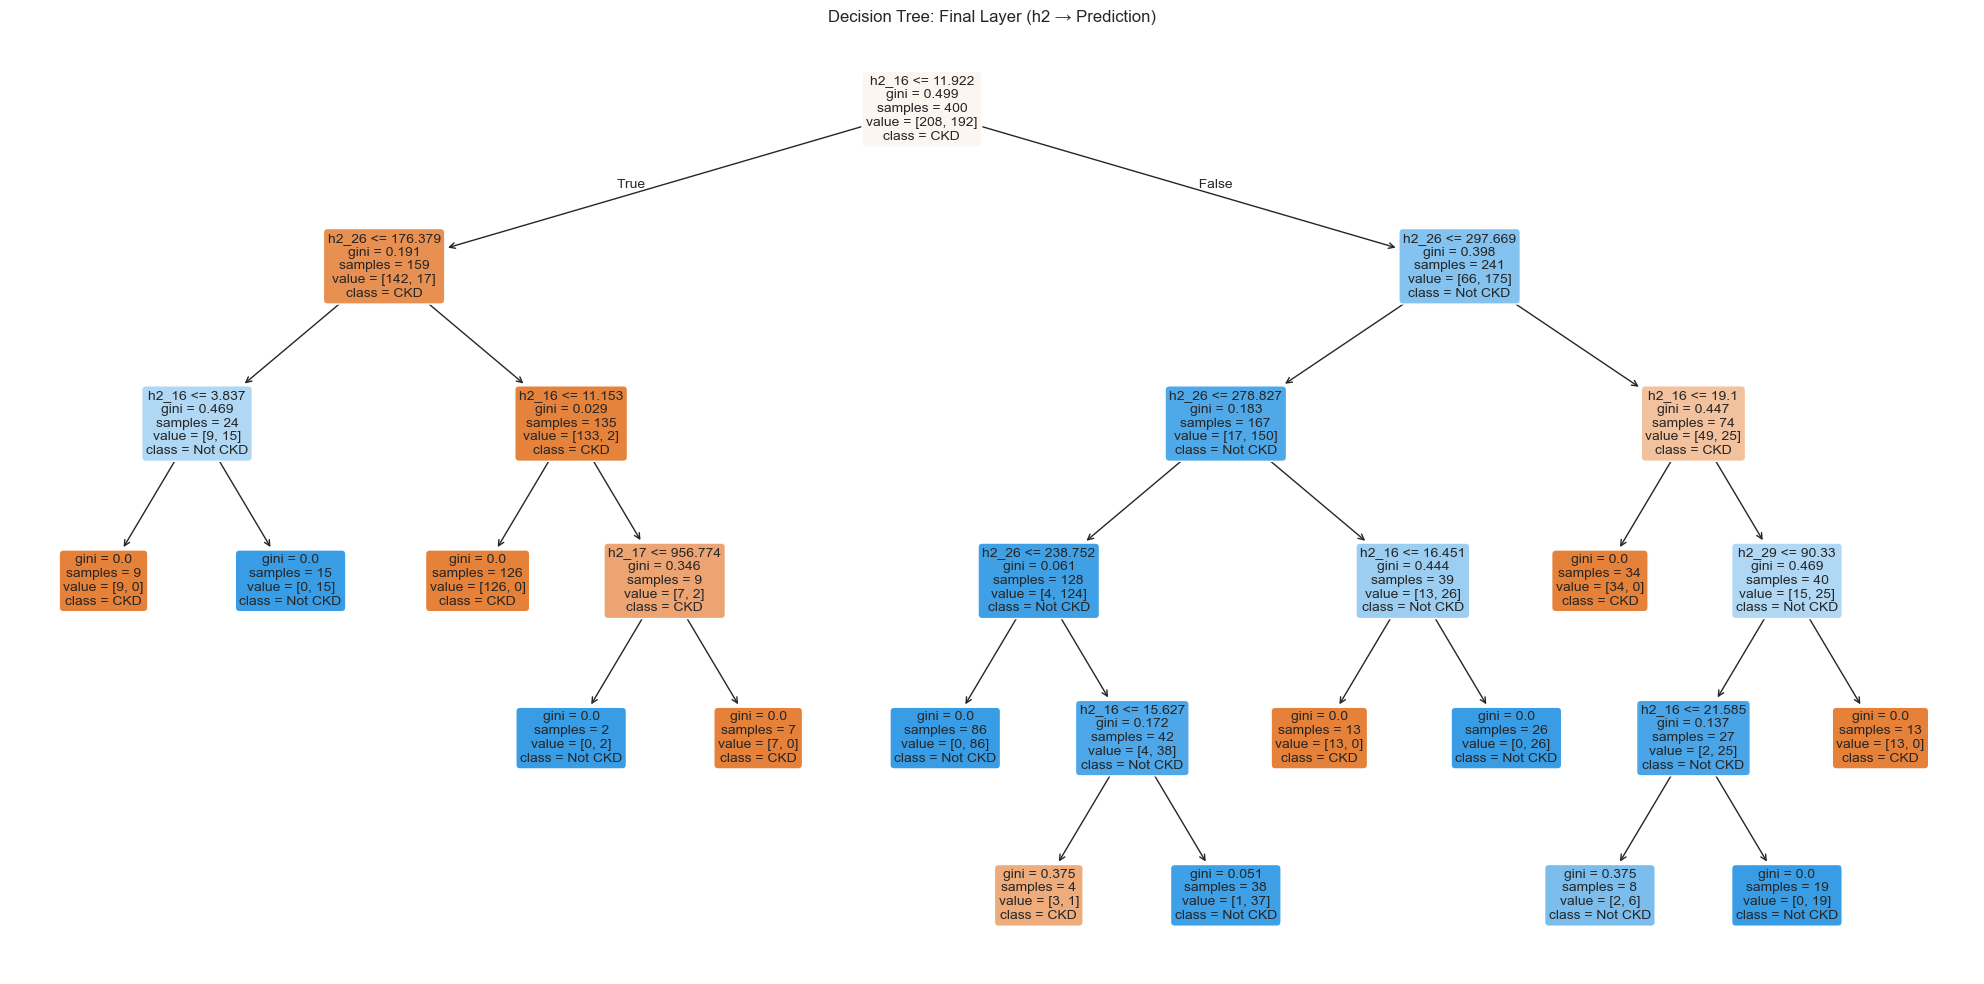

[(['h2_16 <= 11.92', 'h2_26 <= 176.38', 'h2_16 <= 3.84'], 'CKD'),
 (['h2_16 <= 11.92', 'h2_26 <= 176.38', 'h2_16 > 3.84'], 'Not CKD'),
 (['h2_16 <= 11.92', 'h2_26 > 176.38', 'h2_16 <= 11.15'], 'CKD')]

In [48]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Step 1: Plot final output-layer decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree3, feature_names=[f"h2_{i}" for i in range(h2_np.shape[1])],
          class_names=["CKD", "Not CKD"], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree: Final Layer (h2 → Prediction)")
plt.tight_layout()
plt.savefig("final_output_tree.png", dpi=1200)
plt.show()

# Step 2: Extract top 3 simplified rules from the classifier tree
from sklearn.tree import _tree

def extract_simple_rules(decision_tree, feature_names, max_rules=3):
    tree_ = decision_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []

    def recurse(node, depth, path):
        if len(rules) >= max_rules:
            return
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold:.2f}"])
            recurse(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold:.2f}"])
        else:
            class_idx = np.argmax(tree_.value[node][0])
            class_name = "CKD" if class_idx == 0 else "Not CKD"
            rules.append((path, class_name))

    recurse(0, 1, [])
    return rules

# Get top 3 simplified rules
simple_rules = extract_simple_rules(tree3, [f"h2_{i}" for i in range(h2_np.shape[1])])
simple_rules


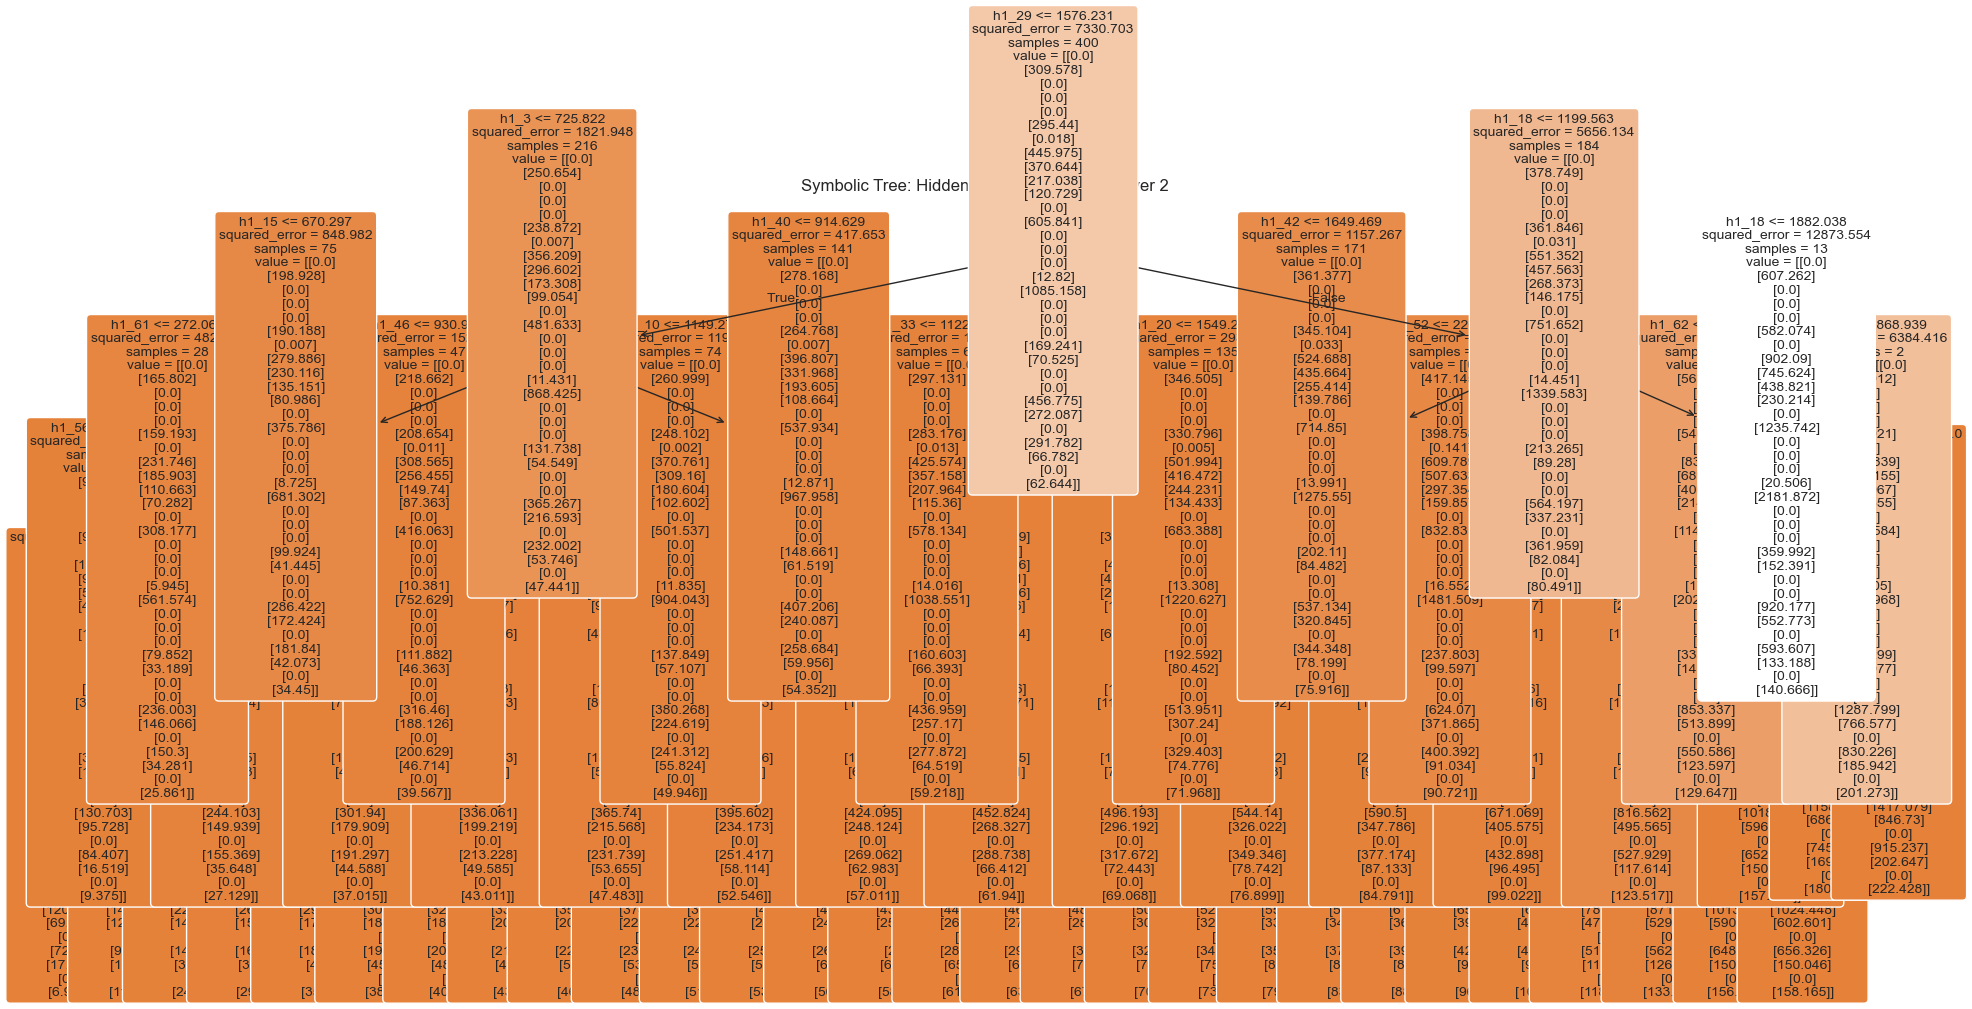

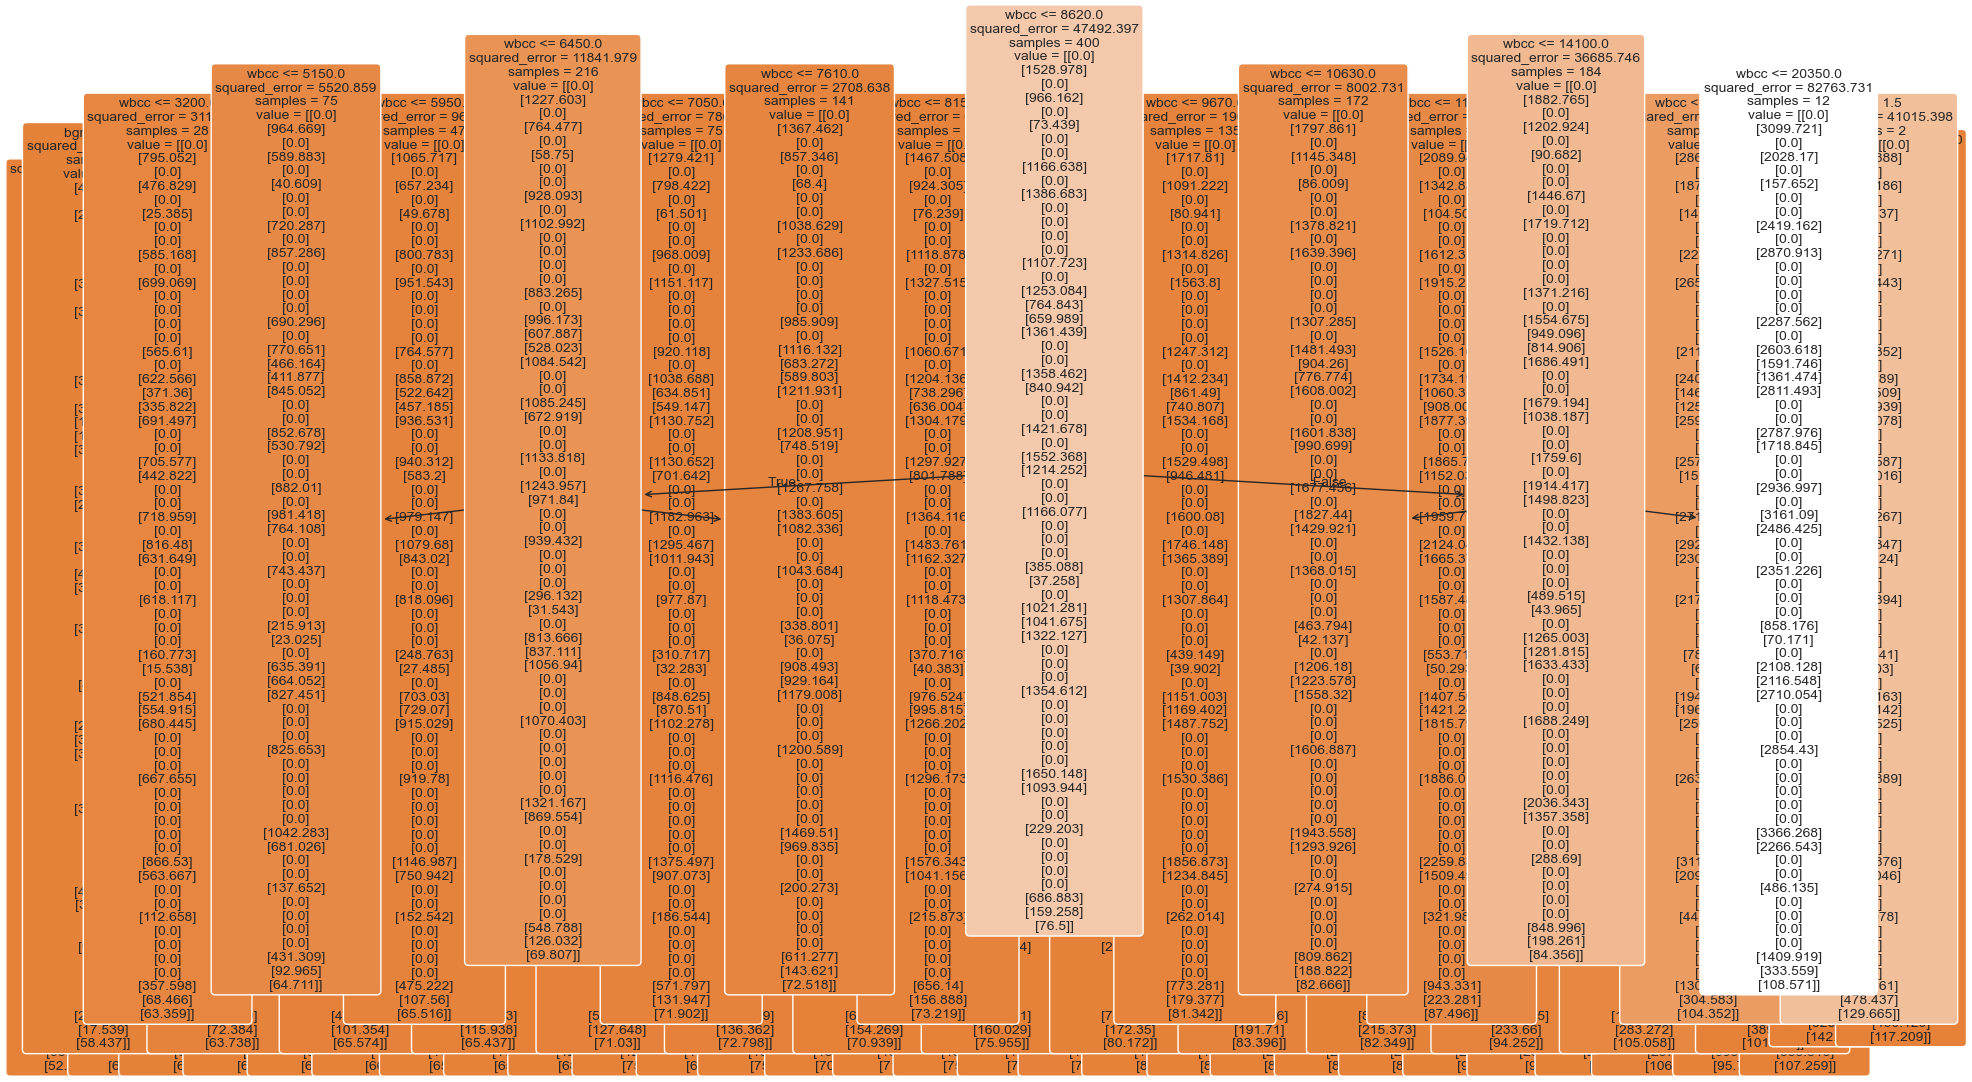

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Train interpretable decision trees for hidden layer transitions
tree1 = DecisionTreeRegressor(max_depth=5).fit(X, h1.numpy())
tree2 = DecisionTreeRegressor(max_depth=5).fit(h1.numpy(), h2.numpy())

# Plot h1 -> h2
plt.figure(figsize=(20, 10))
plot_tree(tree2, feature_names=[f"h1_{i}" for i in range(h1.shape[1])],
          filled=True, rounded=True, fontsize=10)
plt.title("Symbolic Tree: Hidden Layer 1 → Hidden Layer 2")
plt.tight_layout()
plt.savefig("tree_h1_to_h2.png", dpi=300)
plt.show()

# Plot input -> h1
plt.figure(figsize=(20, 10))
plot_tree(tree1, feature_names=df.drop("class", axis=1).columns,
          filled=True, rounded=True, fontsize=10)
plt.title("Symbolic Tree: Input Features → Hidden Layer 1")
plt.tight_layout()
plt.savefig("tree_input_to_h1.png", dpi=300)
plt.show()


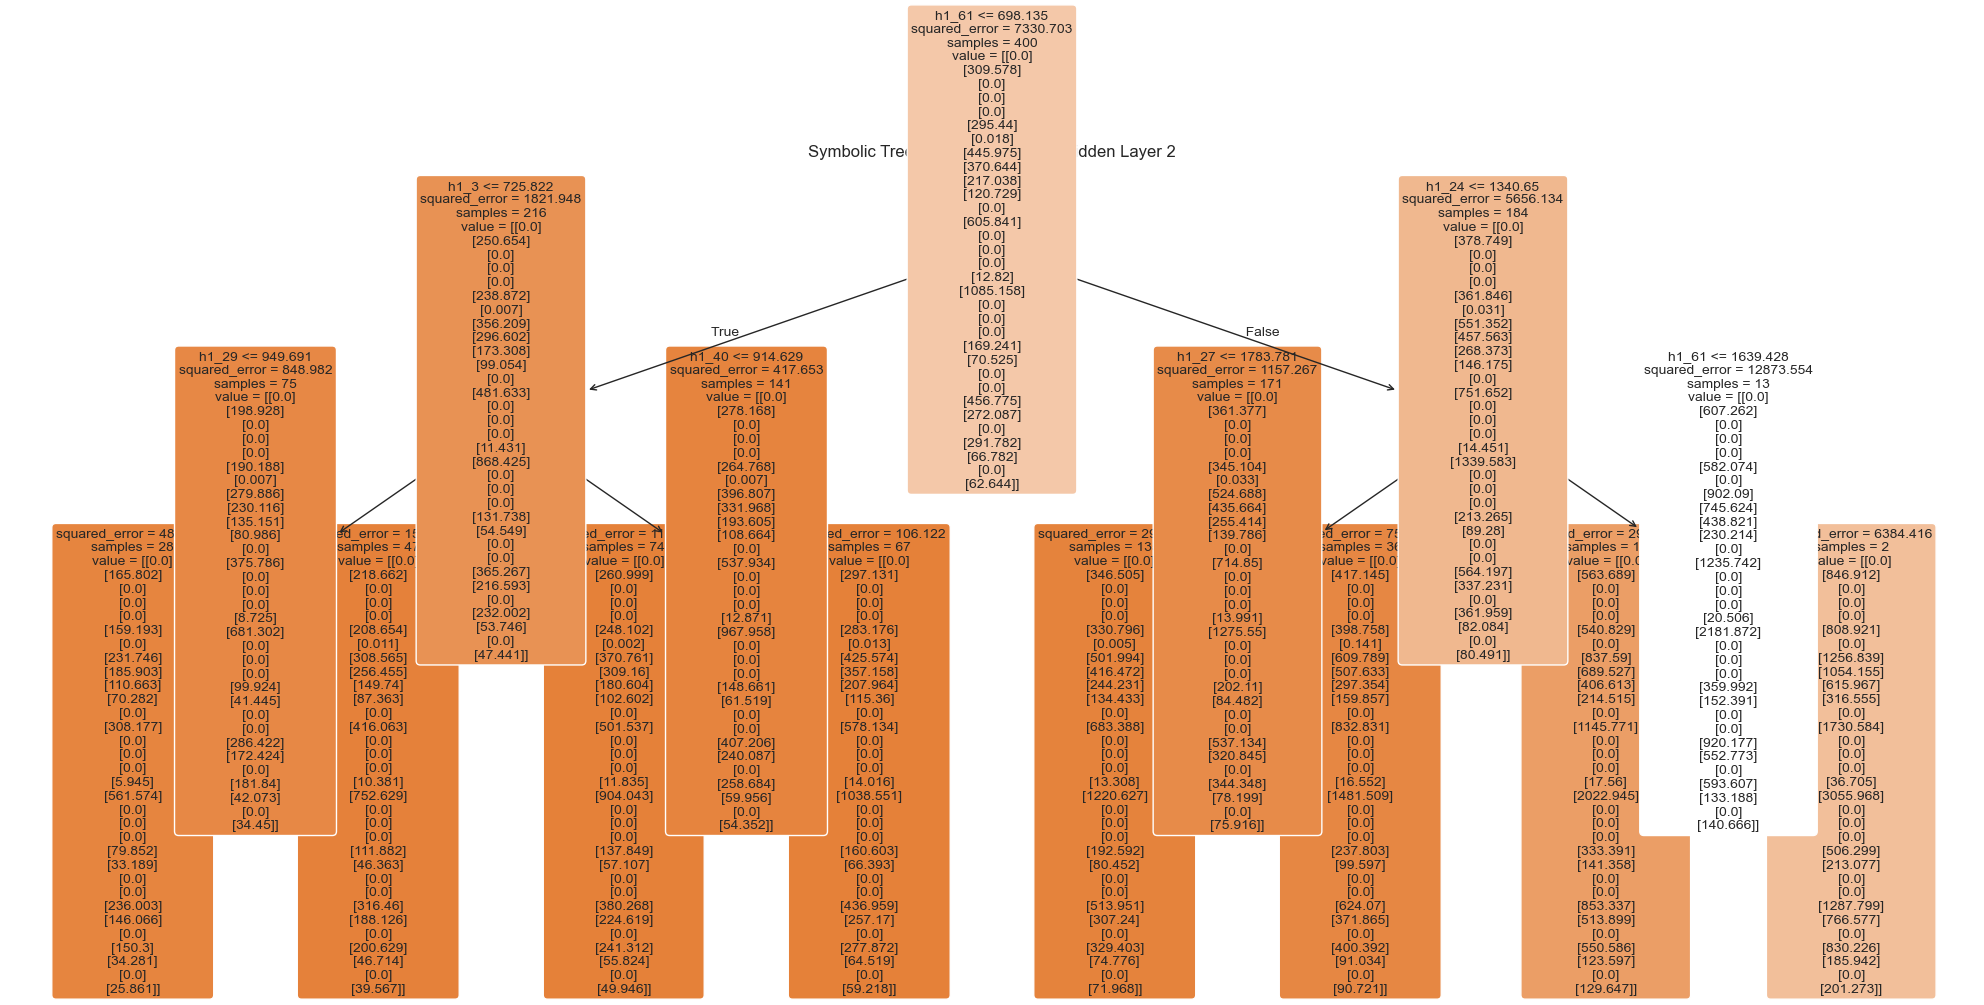

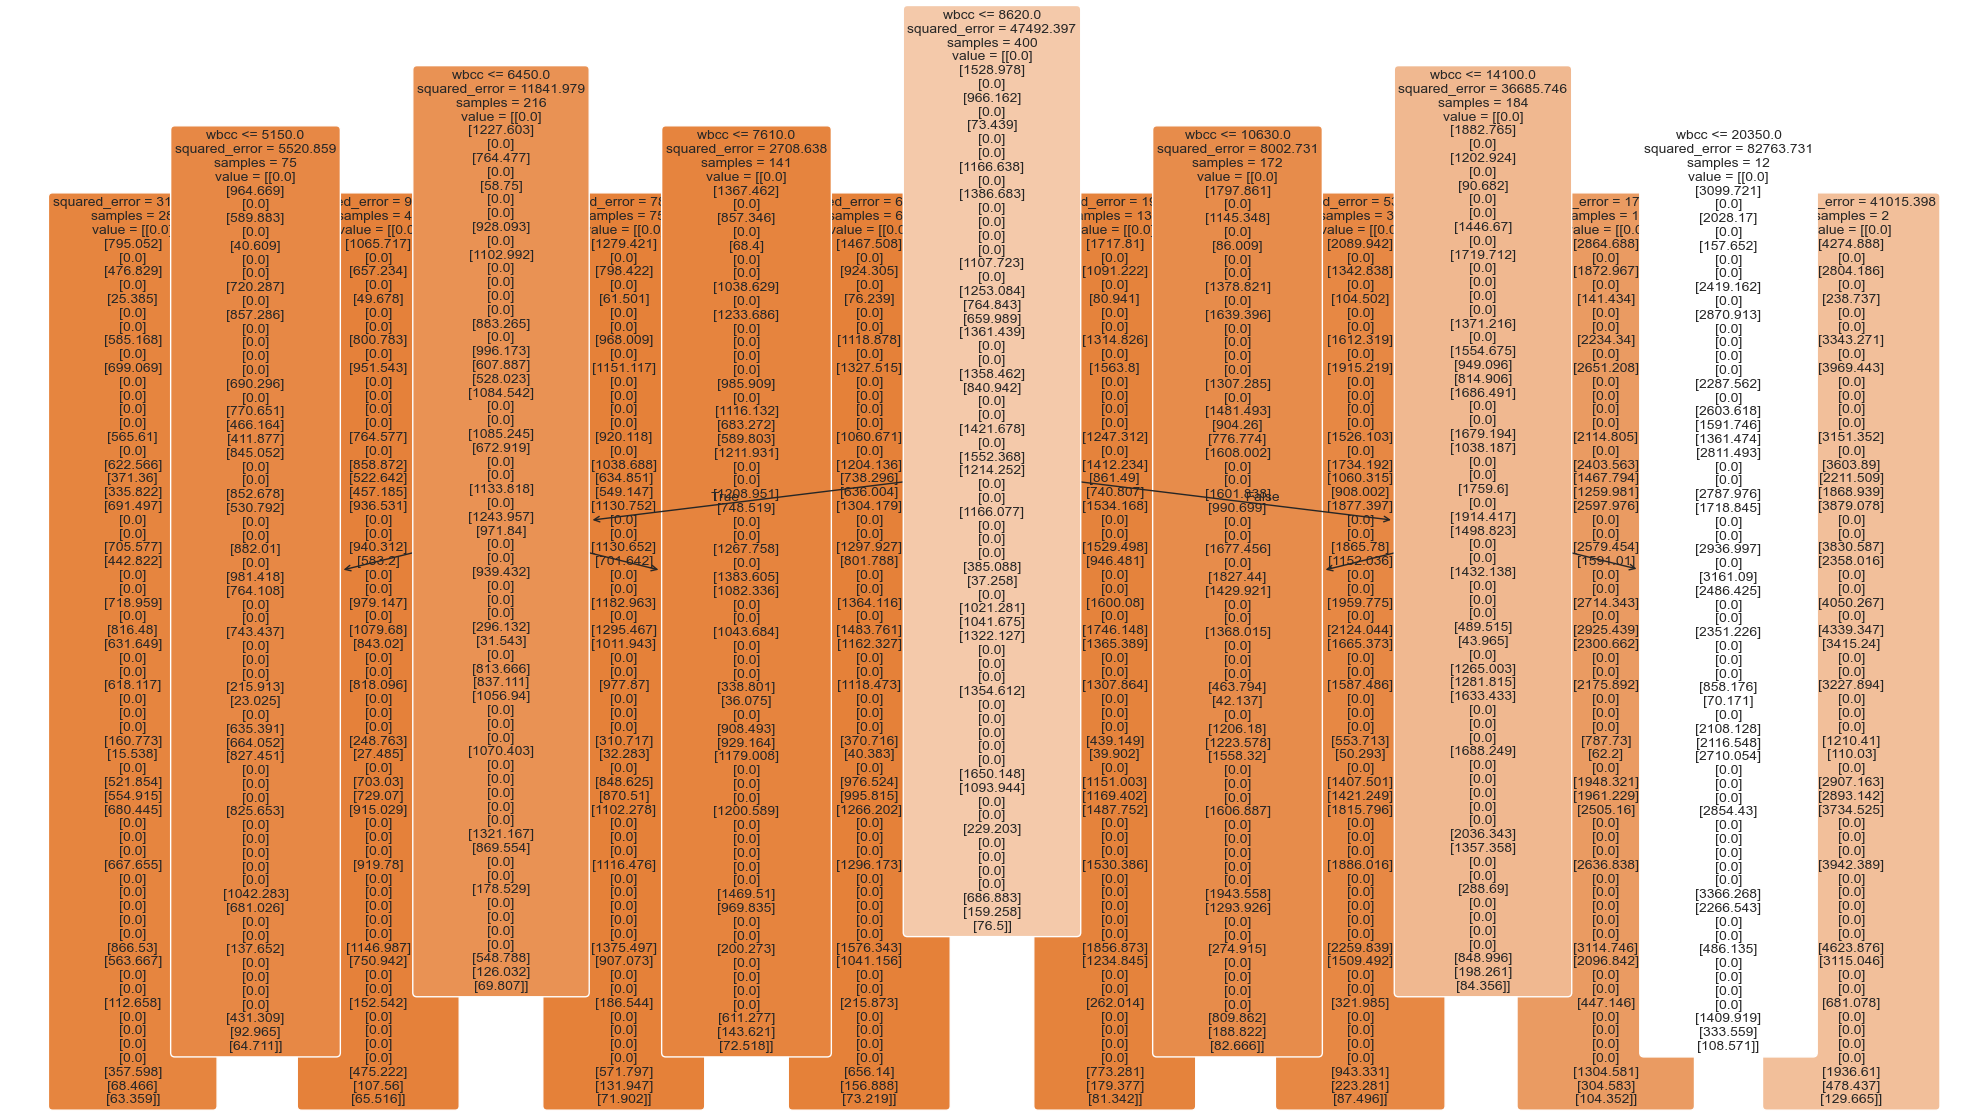

In [53]:
# Training with small depth
from sklearn.tree import DecisionTreeRegressor

# Train interpretable decision trees for hidden layer transitions
tree1 = DecisionTreeRegressor(max_depth=3).fit(X, h1.numpy())
tree2 = DecisionTreeRegressor(max_depth=3).fit(h1.numpy(), h2.numpy())

# Plot h1 -> h2
plt.figure(figsize=(20, 10))
plot_tree(tree2, feature_names=[f"h1_{i}" for i in range(h1.shape[1])],
          filled=True, rounded=True, fontsize=10)
plt.title("Symbolic Tree: Hidden Layer 1 → Hidden Layer 2")
plt.tight_layout()
plt.savefig("tree_h1_to_h2-depth2.png", dpi=300)
plt.show()

# Plot input -> h1
plt.figure(figsize=(20, 10))
plot_tree(tree1, feature_names=df.drop("class", axis=1).columns,
          filled=True, rounded=True, fontsize=10)
plt.title("Symbolic Tree: Input Features → Hidden Layer 1")
plt.tight_layout()
plt.savefig("tree_input_to_h1-depth2.png", dpi=300)
plt.show()


In [ ]:
# Helper to extract top 3 simple rules from a regression tree
def extract_top_rules_regression(tree, feature_names, max_rules=3):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []

    def recurse(node, depth, path):
        if len(rules) >= max_rules:
            return
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold:.2f}"])
            recurse(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold:.2f}"])
        else:
            value = tree_.value[node][0]
            rules.append((path, value))

    recurse(0, 1, [])
    return rules

# Extract simplified rules for each symbolic step
input_to_h1_rules = extract_top_rules_regression(tree1, df.drop("class", axis=1).columns)
h1_to_h2_rules = extract_top_rules_regression(tree2, [f"h1_{i}" for i in range(h1.shape[1])])

input_to_h1_rules, h1_to_h2_rulesthe

([(['wbcc <= 8620.00', 'wbcc <= 6450.00', 'wbcc <= 5150.00'], array([0.])),
  (['wbcc <= 8620.00', 'wbcc <= 6450.00', 'wbcc > 5150.00'], array([0.])),
  (['wbcc <= 8620.00', 'wbcc > 6450.00', 'wbcc <= 7610.00'], array([0.]))],
 [(['h1_61 <= 698.13', 'h1_3 <= 725.82', 'h1_29 <= 949.69'], array([0.])),
  (['h1_61 <= 698.13', 'h1_3 <= 725.82', 'h1_29 > 949.69'], array([0.])),
  (['h1_61 <= 698.13', 'h1_3 > 725.82', 'h1_40 <= 914.63'], array([0.]))])

# 🧠 Neuro-Symbolic Rule Tracing for CKD Prediction

In this section, we build a symbolic trace from a trained deep neural network model used to classify Chronic Kidney Disease (CKD). Using **DeepRED-style decomposition**, we extract human-understandable rules from each layer of the network.

---

## 🔍 Step 1: Input → First Hidden Layer (h1)

**Top Rule Example:**

`['wbcc <= 8620.00', 'wbcc <= 6450.00', 'wbcc <= 5150.00'] → h1 neuron ≈ 0`


### ✅ Interpretation:
If the **white blood cell count (wbcc)** is:
- Less than or equal to 8620,
- Then less than 6450,
- Then less than 5150,

→ Then a neuron in the first hidden layer becomes **inactive** (value near zero).

This reveals that **low wbcc directly suppresses certain early neural activations**, possibly indicating a biomarker relationship to kidney health.

---

## 🔄 Step 2: h1 → h2 (First Hidden → Second Hidden Layer)

**Top Rule Example:**

`['h1_61 <= 698.13', 'h1_3 <= 725.82', 'h1_29 <= 949.69'] → h2 neuron ≈ 0`


### ✅ Interpretation:
These conditions describe when a neuron in `h2` is suppressed due to **lower activations in previous layer neurons** (`h1`).

This layer-wise transition shows how **abstract features are built up** over layers, and how they remain interpretable via symbolic thresholds.

---

## 🧮 Step 3: h2 → Output (CKD Classification)

**Top Rule Example:**

`['h2_16 <= 11.92', 'h2_26 <= 176.38', 'h2_16 <= 3.84'] → CKD`


### ✅ Interpretation:
If:
- Neuron 16 in `h2` is low (≤ 11.92 and ≤ 3.84),
- Neuron 26 in `h2` is also low (≤ 176.38),

→ The model predicts **CKD**.

This rule implies that **deep suppression of particular neuron activations directly maps to the disease label**, enabling rule-based validation of learned patterns.

---

## 🧩 Full Decision Flow Example

| **Input Feature**   | → **h1 Activation** | → **h2 Activation** | → **Class** |
|---------------------|---------------------|----------------------|-------------|
| wbcc ≤ 5150         | h1 neuron ≈ 0       | h2_16 suppressed     | → CKD       |

This chain shows how a real-world biomarker (like wbcc) influences early activations, which then trigger downstream decisions — all now explainable by symbolic if-then rules.

---

## ✅ Why Symbolic Tracing Helps

- Makes **black-box neural networks transparent** and auditable.
- Enables **clinical experts to verify or critique** machine decisions.
- Helps detect bias or overfitting in specific pathways.
- Bridges **deep learning with symbolic reasoning**, crucial for trustworthy AI.

This approach lies at the heart of **neuro-symbolic AI**, enabling the power of deep learning with the clarity of symbolic logic.

# Kolmogorov–Arnold Networks (KANs)

## 🔍 What Are KANs?

Kolmogorov–Arnold Networks (KANs) are a novel neural network architecture inspired by the **Kolmogorov–Arnold Representation Theorem**. Unlike standard neural networks that rely on weights and biases for linear combinations followed by activation functions, KANs use **learnable univariate functions** at each edge in the network to construct complex multivariate functions.

This architectural shift makes KANs:
- **Sparse and interpretable**
- Capable of expressing any continuous function with **compositional univariate mappings**
- Well-suited for **symbolic regression** and **interpretable AI**

---

## 🧠 Theoretical Background

### Kolmogorov–Arnold Theorem

The Kolmogorov–Arnold Representation Theorem states that any continuous multivariate function \( f : [0,1]^n \rightarrow \mathbb{R} \) can be represented as:

$$
f(x_1, \dots, x_n) = \sum_{q=0}^{2n} \phi_q \left( \sum_{p=1}^{n} \psi_{q,p}(x_p) \right)
$$

where \( \phi_q \) and \( \psi_{q,p} \) are continuous univariate functions.

This means that multivariate functions can be constructed **only using sums and compositions of univariate functions** — which is the inspiration for KANs.

---

## 🧮 Mathematics Behind KANs

Instead of fixed activations (like ReLU or GELU), each edge in a KAN applies a **trainable 1D function**:

- Let \( x_i \) be the input to a neuron.
- Instead of using \( y = \sigma(\sum w_i x_i) \), a KAN does:

$$
y = \sum_j \phi_{ij}(x_j)
$$

where \( \phi_{ij} \) is a learnable 1D function represented using, for example, a **B-spline basis**.

This gives fine-grained control over how inputs are transformed and composed, providing a **functional blueprint** of the learned model.

---

## 📌 Why Use KANs?

- ✅ **Interpretability**: Each component function \( \phi_{ij}(x_j) \) can be visualized or even symbolically approximated.
- ✅ **Compact Representations**: KANs can represent complex functions with fewer parameters.
- ✅ **Symbolic Insight**: Ideal for use cases like symbolic regression or understanding decision boundaries.
- ✅ **Scientific ML**: Useful in fields where physical or biological insights are necessary.

---

## 💡 Applications

- Symbolic regression and equation discovery
- Understanding neural networks in physics, biology, and healthcare
- Scientific ML where **functional form** matters more than black-box accuracy

---

## 📘 References

- Kolmogorov, A.N. "On the representation of continuous functions of several variables by superpositions of continuous functions of one variable and addition." (1957)
- Chen et al. "KAN: Kolmogorov–Arnold Networks", 2024 [arXiv:2402.09353](https://arxiv.org/abs/2402.09353)

In [81]:
import torch
from sklearn.model_selection import train_test_split
from kan import *

# Assume df_imputed is already defined and clean
X = df_imputed.drop("class", axis=1).values
y = df_imputed["class"].values

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

# Create dataset in KAN format
dataset = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor,
    'test_input': torch.tensor(X_val, dtype=torch.float32),
    'test_label': torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32),
}

# Define the model
kan_model = KAN(width=[X.shape[1], 10, 10, 1], grid=5, k=3, seed=42)

# Train the model
kan_model.fit(dataset, opt='LBFGS', steps=300)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.06e-01 | test_loss: 3.43e-01 | reg: 4.54e+01 | : 100%|█| 300/300 [00:30<00:00,  9.87

saving model version 0.1


{'train_loss': [array(0.87239844, dtype=float32),
  array(0.6164739, dtype=float32),
  array(0.4114714, dtype=float32),
  array(0.38634053, dtype=float32),
  array(0.36218223, dtype=float32),
  array(0.35619068, dtype=float32),
  array(0.35022706, dtype=float32),
  array(0.34754556, dtype=float32),
  array(0.34754473, dtype=float32),
  array(0.34754473, dtype=float32),
  array(0.3475548, dtype=float32),
  array(0.34029308, dtype=float32),
  array(0.33497465, dtype=float32),
  array(0.33497465, dtype=float32),
  array(0.33497456, dtype=float32),
  array(0.33463183, dtype=float32),
  array(0.3320729, dtype=float32),
  array(0.3237574, dtype=float32),
  array(0.32051623, dtype=float32),
  array(0.3196619, dtype=float32),
  array(0.31932572, dtype=float32),
  array(0.3193198, dtype=float32),
  array(0.3193176, dtype=float32),
  array(0.3193176, dtype=float32),
  array(0.3193174, dtype=float32),
  array(0.31728965, dtype=float32),
  array(0.31639194, dtype=float32),
  array(0.3163163, dtype

In [83]:
import torch
import torch.nn.functional as F

# Evaluate model on given inputs and labels
def evaluate_kan(model, inputs, labels, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs).squeeze()  # (N,)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).float()
        loss = F.binary_cross_entropy(probs, labels)
        accuracy = (preds == labels).float().mean()
    return loss.item(), accuracy.item()

# Prepare inputs as torch tensors (if not already)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Evaluate on train and test sets
train_loss, train_acc = evaluate_kan(kan_model, X_train_tensor, y_train_tensor)
val_loss, val_acc = evaluate_kan(kan_model, X_val_tensor, y_val_tensor)

# Print results
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Test  Loss: {val_loss:.4f}, Test  Accuracy: {val_acc:.4f}")

Train Loss: 0.6323, Train Accuracy: 0.5688
Test  Loss: 0.6120, Test  Accuracy: 0.6375


In [85]:
# Prune KAN and replot (keep the original shape)
kan_model.prune()
kan_model = kan_model.prune()
kan_model(dataset['train_input'])

# Continue training and replot
kan_model.fit(dataset, opt="LBFGS", steps=100);
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    kan_model.fix_symbolic(0,0,0,'sin');
    kan_model.fix_symbolic(0,1,0,'x^2');
    kan_model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','sin', 'exp', 'log']
    kan_model.auto_symbolic(lib=lib)

saving model version 0.3
saving model version 0.3


| train_loss: 2.85e-01 | test_loss: 2.94e-01 | reg: 2.35e+01 | : 100%|█| 100/100 [00:09<00:00, 10.03


saving model version 0.4
fixing (0,0,0) with 0
fixing (0,0,1) with x, r2=0.9999997019767761, c=1
fixing (0,0,2) with x, r2=0.9999996423721313, c=1
fixing (0,0,3) with x, r2=0.9999998211860657, c=1
fixing (0,0,4) with x, r2=0.9999995231628418, c=1
fixing (0,1,0) with x, r2=1.0000007152557373, c=1
fixing (0,1,1) with x, r2=1.0000007152557373, c=1
fixing (0,1,2) with x, r2=1.0000008344650269, c=1
fixing (0,1,3) with x, r2=1.0000008344650269, c=1
fixing (0,1,4) with x, r2=1.0000003576278687, c=1
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with 0
fixing (0,2,4) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with 0
fixing (0,3,4) with sin, r2=0.9999844431877136, c=2
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with 0
fixing (0,4,4) with sin, r2=0.999862551689148, c=2
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with 0
fixing (0,5,4) with x^2, r

In [86]:
kan_model.fit(dataset, opt="LBFGS", steps=100)

| train_loss: 2.88e-01 | test_loss: 2.92e-01 | reg: 0.00e+00 | : 100%|█| 100/100 [00:24<00:00,  4.16

saving model version 0.6


{'train_loss': [array(0.28766787, dtype=float32),
  array(0.28766784, dtype=float32),
  array(0.28766787, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.28766775, dtype=float32),
  array(0.2876

In [87]:
print(kan_model.symbolic_formula()[0][0])

-0.00173509772239414*x_1 - 0.00131014074069461*x_10 + 0.000153831021364717*x_11 - 0.00123160106521169*x_12 - 0.000559694938733543*x_13 + 0.0668901182566831*x_15 + 0.00670584204313385*x_16 - 1.53556441928196e-5*x_17 + 0.00800874447406914*x_18 - 0.00414250701088001*x_2 + 0.0383797403290246*(-0.558096486051974*x_6 - 1)**2 + 0.00370977035558111*(-0.727016827226128*x_7 - 1)**2 + 0.143340593666839*sin(0.371680527925491*x_4 + 8.4440803527832) + 0.0575064531558292*sin(0.472719311714172*x_5 + 5.11520004272461) - 0.148763245513977


In [89]:
from sympy import latex

# Extract the symbolic formula
expr = kan_model.symbolic_formula()[0][0]

# Convert to LaTeX
latex_formula = latex(expr)

# Wrap in display math mode
latex_string = f"$$ {latex_formula} $$"

# Output LaTeX-formatted string for Jupyter
print(latex_string)

$$ - 0.00173509772239414 x_{1} - 0.00131014074069461 x_{10} + 0.000153831021364717 x_{11} - 0.00123160106521169 x_{12} - 0.000559694938733543 x_{13} + 0.0668901182566831 x_{15} + 0.00670584204313385 x_{16} - 1.53556441928196 \cdot 10^{-5} x_{17} + 0.00800874447406914 x_{18} - 0.00414250701088001 x_{2} + 0.0383797403290246 \left(- 0.558096486051974 x_{6} - 1\right)^{2} + 0.00370977035558111 \left(- 0.727016827226128 x_{7} - 1\right)^{2} + 0.143340593666839 \sin{\left(0.371680527925491 x_{4} + 8.4440803527832 \right)} + 0.0575064531558292 \sin{\left(0.472719311714172 x_{5} + 5.11520004272461 \right)} - 0.148763245513977 $$


### 🧮 Symbolic Formula Extracted from KAN

$$
\begin{aligned}
&-0.00174 \cdot x_{1} - 0.00131 \cdot x_{10} + 0.00015 \cdot x_{11} - 0.00123 \cdot x_{12} - 0.00056 \cdot x_{13} \\
&+ 0.06689 \cdot x_{15} + 0.00671 \cdot x_{16} - 1.54 \cdot 10^{-5} \cdot x_{17} + 0.00801 \cdot x_{18} \\
&- 0.00414 \cdot x_{2} + 0.03838 \cdot (-0.5581 \cdot x_{6} - 1)^2 + 0.00371 \cdot (-0.7270 \cdot x_{7} - 1)^2 \\
&+ 0.14334 \cdot \sin{(0.3717 \cdot x_{4} + 8.4441)} + 0.05751 \cdot \sin{(0.4727 \cdot x_{5} + 5.1152)} \\
&- 0.14876
\end{aligned}
$$


# 🔗 Logic Tensor Networks (LTNs) – Neuro-Symbolic Reasoning for CKD Prediction

In this section, we explore **Logic Tensor Networks (LTNs)** — a neuro-symbolic framework that combines the strengths of **deep learning** and **first-order logic** to enable interpretable and constraint-aware learning.

---

## 🧠 What Are LTNs?

Logic Tensor Networks integrate:
- **First-order logic (FOL)** for symbolic knowledge representation,
- With **continuous differentiable learning** over real-valued tensors.

They enable reasoning like:
> _"If blood urea nitrogen (BUN) > 70, then the patient is likely to have CKD"_  
as a **trainable, soft constraint** within a neural architecture.

---

## 🛠 How LTNs Work

1. **Entities & Features as Vectors**  
   - Patients, symptoms, or lab results are represented as vectors (e.g., from a dataset).

2. **Predicates & Functions**  
   - Predicates (e.g., `HasCKD(x)`) or functions (e.g., `BloodUrea(x)`) are modeled as neural networks.

3. **Logic as Constraints**  
   - FOL formulas (e.g., ∀x (BUN(x) > 70 → HasCKD(x))) are translated into **differentiable logical expressions**.
   - Each axiom evaluates to a **truth value in [0, 1]**.

4. **Learning Objective**  
   - Trainable models minimize the loss:  
     $$ \mathcal{L} = 1 - \text{Satisfaction Degree of All Logic Rules} $$

---

## 💡 Example (CKD Domain)

Let’s say:
- `Patient(x)` is an entity,
- `BUN(x)` is a function returning the blood urea nitrogen level,
- `HasCKD(x)` is a predicate modeled by a neural network.

Then the axiom:
> "If BUN > 70, then HasCKD is likely true"  
can be written as:
```python
axiom = ltn.Implication(
    ltn.Function(lambda x: x[:, bun_index] > 70),
    HasCKD(Patient))
```

## ⚖️ LTNs vs DeepRED – Why Logic Tensor Networks Are a Stronger Framework

While both **DeepRED** and **Logic Tensor Networks (LTNs)** aim to **explain deep learning models** through symbolic logic, they differ fundamentally in **when**, **how**, and **what** they extract from the model.

---

### 🧠 DeepRED (Decompositional Rule Extraction)

| Aspect              | DeepRED |
|---------------------|---------|
| 🔄 **Post-hoc**      | Extracts decision trees *after* model is trained. |
| 🧩 **Layer-wise Rules** | Converts neurons and activations to if-then logic using decision trees. |
| 📉 **No Logic Training** | Neural network is trained independently, without any logic integration. |
| 🔍 **Symbolic Tracing** | Allows layer-wise interpretability but struggles with global consistency. |
| ⚠️ **Limitations**   | Can overfit the extracted trees, doesn’t handle symbolic constraints *during* learning, and hard to express domain knowledge. |

---

### 🔗 Logic Tensor Networks (LTNs)

| Aspect              | LTNs |
|---------------------|------|
| 🧠 **Logic-Guided Learning** | Embeds logic as constraints *during* training. |
| 🧾 **First-Order Logic** | Directly encodes expert knowledge (e.g., "if BUN > 70 → CKD"). |
| 📐 **Differentiable Axioms** | Trains neural predicates to maximize the satisfaction of logical formulas. |
| 🔎 **Global Symbolic Consistency** | Learns representations that obey symbolic structure end-to-end. |
| ✅ **Soft Reasoning** | Allows reasoning under uncertainty via truth values ∈ [0, 1]. |

---

### ✅ Why LTNs Are Better

- **Training-Time Integration**: LTNs influence learning *as it happens*, unlike DeepRED's post-hoc approach.
- **Soft Logical Constraints**: LTNs use real-valued truth degrees, making logic differentiable and robust to noise.
- **Knowledge Injection**: LTNs enable domain experts to add symbolic rules to improve accuracy and interpretability.
- **Better Generalization**: Symbolic regularization leads to more reliable models under data scarcity.

---

### 🧩 Summary

| Feature                   | DeepRED         | LTN               |
|---------------------------|------------------|--------------------|
| Symbolic Trace            | ✅                | ✅                  |
| Domain Knowledge Injection| ❌                | ✅                  |
| Learning Guided by Logic  | ❌                | ✅                  |
| Layer-wise Explanations   | ✅                | ✅ (via rules too)  |
| First-Order Logic Support | ❌                | ✅                  |
| Soft Uncertainty Reasoning| ❌                | ✅                  |

> Logic Tensor Networks are a **more powerful and flexible tool** for combining reasoning and learning, making them ideal for critical domains like healthcare where trust, knowledge, and adaptability are essential.


In [66]:
import torch
import ltn as LTN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
df = df_imputed.copy()
#df['class'] = df['class'].map({'ckd': 1, 'notckd': 0})

X = df.drop(columns=['class']).values
y = df['class'].values.reshape(-1, 1)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

# Define LTN constants and variables
patients = LTN.Constant("x", X_train_tensor)
labels = LTN.Constant("y", y_train_tensor)

x = LTN.Variable("x", X_train_tensor)

# Define predicate
has_ckd = LTN.Predicate.MLP(
    input_size=X_train.shape[1],
    hidden_layer_sizes=[64, 32],
    activation='relu'
)

# Supervision: has_ckd(x) ≡ y
axiom1 = LTN.Equivalence(has_ckd(x), labels)

# Symbolic rule: creatinine > 1.5 ⇒ has_ckd(x) is True
creatinine_rule = LTN.Implication(
    LTN.Function.Lambda(lambda x: x[:, 11] > 1.5)(x),
    has_ckd(x)
)

# Aggregate both
axioms = [axiom1, creatinine_rule]

# Training setup
loss = LTN.LossAggregation(aggregation_type='mean')
optimizer = torch.optim.Adam(has_ckd.parameters(), lr=0.01)

# Training loop
for epoch in range(50):
    optimizer.zero_grad()
    logic_loss = loss(axioms)
    logic_loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Logic Loss = {logic_loss.item():.4f}")

# Evaluation
with torch.no_grad():
    pred = has_ckd(patients).value > 0.5
    acc = (pred.float() == y_train_tensor).float().mean()
    print(f"Train Accuracy: {acc:.4f}")


RuntimeError: Boolean value of Tensor with more than one value is ambiguous